<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import" data-toc-modified-id="Import-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import</a></span><ul class="toc-item"><li><span><a href="#Librairies" data-toc-modified-id="Librairies-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Librairies</a></span></li><li><span><a href="#Fonctions" data-toc-modified-id="Fonctions-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Fonctions</a></span></li><li><span><a href="#Données" data-toc-modified-id="Données-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Données</a></span></li></ul></li><li><span><a href="#Exploration-des-données" data-toc-modified-id="Exploration-des-données-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Exploration des données</a></span></li><li><span><a href="#Test-Fonctions" data-toc-modified-id="Test-Fonctions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Test Fonctions</a></span></li><li><span><a href="#Pipeline" data-toc-modified-id="Pipeline-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Pipeline</a></span></li><li><span><a href="#Graphiques" data-toc-modified-id="Graphiques-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Graphiques</a></span></li><li><span><a href="#ACP" data-toc-modified-id="ACP-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>ACP</a></span></li><li><span><a href="#Feature-Engineering" data-toc-modified-id="Feature-Engineering-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Feature Engineering</a></span></li></ul></div>

# Import
## Librairies

In [1]:
# Data
import pandas as pd
import numpy as np

# Graphics
import matplotlib.pyplot as plt
import seaborn as sns

# Pre-processing
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import TargetEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

# Compose
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

# Decompostion
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

# Warnings
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

## Fonctions

In [2]:
class MissingColumnsException(Exception):
    """
    Exception qui affiche les colonnes manquantes lors de la vérification.
    
    Args:
        message (str): Description de l'erreur
        missing_columns (list): Liste des colonnes manquantes à afficher dans le message
    """

    def __init__(self, message, missing_columns):
        self.message = f"Il manque une ou plusieurs colonnes : {missing_columns}"
        super().__init__(self.message)


def check_columns_presence(df, columns_to_test):
    """
    Fonction qui vérifie la présence des colonnes dans le DataFrame
    Si les colonnes sont présentes, retourne un booléen, affiche l'erreur avec les colonnes manquantes
    
    Args: 
        df: DataFrame dans lequel faire la vérification
        columns_to_test: liste des colonnes à vérifier
        
    Return:
        True si toutes les colonnes sont présentes, sinon soulève l'exception
        
    Raises:
        MissingColumnsError: Si au moins une colonnes est manquante
    """

    columns_df = df.columns
    columns_missing = []

    for col in columns_to_test:
        if col not in columns_df:
            columns_missing.append(col)

    if len(columns_missing) > 0:
        raise MissingColumnsException("", columns_missing)
    else:
        return True


def keep_columns(df):
    """
    Fonction qui retourne le DataFrame avec les colonnes utiles
    
    Args: 
        df: DataFrame dans lequel faire la vérification
        
    Return:
        DataFrame trié sur les colonnes
        
    Raises:
        MissingColumnsError: Si au moins une colonnes est manquante
    """
    
    columns_to_keep = [
        "YearBuilt", "NumberofBuildings", "NumberofFloors", "PropertyGFATotal",
        "PropertyGFAParking", "PropertyGFABuilding(s)", "BuildingType",
        "PrimaryPropertyType", "ListOfAllPropertyUseTypes",
        "LargestPropertyUseType", "SecondLargestPropertyUseType",
        "ThirdLargestPropertyUseType", "LargestPropertyUseTypeGFA",
        "SecondLargestPropertyUseTypeGFA", "ThirdLargestPropertyUseTypeGFA",
        "SteamUse(kBtu)", "Electricity(kBtu)", "NaturalGas(kBtu)",
        "SiteEnergyUse(kBtu)", "SiteEUI(kBtu/sf)", "ENERGYSTARScore",
        "TotalGHGEmissions"
    ]

    try:
        check_columns_presence(df, columns_to_keep)

        df = df[columns_to_keep]

        return df

    except MissingColumnsException as e:
        print(f"Il y a une erreur : {e}")


def keep_non_residential_building_types(building_type: str, types: list):
    """
    Fonction qui vérifie si le type de building se trouve dans la liste
    
    Args:
        building_type : le type du building à vérifier
        types : liste des types de building à garder
    
    Return: 
        True si le type est dans la liste
    """

    if building_type in types:
        return True
    else:
        return False


def keep_building_types(df):
    """
    Fonction pour garder les lignes avec les bon types de building (non-residential)
    
    Args:
        df : DataFrame à trier
    
    Return:
        df : DataFrame trié
    """

    building_types_to_keep = [
        type_ for type_ in df["BuildingType"].unique()
        if "Multifamily" not in type_
    ]

    df = df[df.apply(lambda row: keep_non_residential_building_types(
        row["BuildingType"], building_types_to_keep),
                     axis=1)]

    return df


def drop_missing_values_energy_use(df):
    """
    Fonction qui supprime les lignes avec la valeur de SiteEnergyUseWN(kBtu) vide
    
    Args:
        df : DataFrame à trier
    
    Return:
        df : DataFrame trié
    """

    df.dropna(subset="SiteEnergyUse(kBtu)", inplace=True)

    return df


def property_use_type_fill(row):
    """
    Fonction qui remplit les colonnes de PropertyUse 
    en fonction de la colonne ListOfAllPropertyUseTypes
    
    Args:
        row : ligne du DataFrame à remplir
        
    Retrun:
        row : ligne remplie
    """
    
    if pd.isnull(row["LargestPropertyUseType"]):

        property_use_types = str(row["ListOfAllPropertyUseTypes"]).split(", ")

        if len(property_use_types) == 1:
            row["LargestPropertyUseType"] = property_use_types[0]
            row["LargestPropertyUseTypeGFA"] = row["PropertyGFABuilding(s)"]

        elif (len(property_use_types) == 2) & (pd.isnull(
                row["SecondLargestPropertyUseType"])):
            row["LargestPropertyUseType"] = property_use_types[0]
            row["SecondLargestPropertyUseType"] = property_use_types[1]

            row["LargestPropertyUseTypeGFA"] = row[
                "PropertyGFABuilding(s)"] * (1 - secondary_gfa_proportion)
            row["SecondLargestPropertyUseTypeGFA"] = row[
                "PropertyGFABuilding(s)"] * secondary_gfa_proportion

        elif (len(property_use_types) >= 3) & (pd.isnull(
                row["ThirdLargestPropertyUseType"])):

            row["LargestPropertyUseType"] = property_use_types[0]
            row["SecondLargestPropertyUseType"] = property_use_types[1]
            row["ThirdLargestPropertyUseType"] = property_use_types[2]

            row["LargestPropertyUseTypeGFA"] = row[
                "PropertyGFABuilding(s)"] * (1 - secondary_gfa_proportion -
                                             third_gfa_proportion)
            row["SecondLargestPropertyUseTypeGFA"] = row[
                "PropertyGFABuilding(s)"] * secondary_gfa_proportion
            row["ThirdLargestPropertyUseTypeGFA"] = row[
                "PropertyGFABuilding(s)"] * third_gfa_proportion

    elif pd.isnull(row["SecondLargestPropertyUseType"]):
        property_use_types = row["ListOfAllPropertyUseTypes"].split(", ")

        if len(property_use_types) == 2:

            row["SecondLargestPropertyUseType"] = property_use_types[1]
            row["SecondLargestPropertyUseTypeGFA"] = row[
                "PropertyGFABuilding(s)"] * secondary_gfa_proportion

        elif (len(property_use_types) >= 3) & (pd.isnull(
                row["ThirdLargestPropertyUseType"])):

            row["SecondLargestPropertyUseType"] = property_use_types[1]
            row["ThirdLargestPropertyUseType"] = property_use_types[2]

            row["SecondLargestPropertyUseTypeGFA"] = row[
                "PropertyGFABuilding(s)"] * secondary_gfa_proportion
            row["ThirdLargestPropertyUseTypeGFA"] = row[
                "PropertyGFABuilding(s)"] * third_gfa_proportion

    elif pd.isnull(row["ThirdLargestPropertyUseType"]):
        property_use_types = row["ListOfAllPropertyUseTypes"].split(", ")

        if len(property_use_types) >= 3:

            row["ThirdLargestPropertyUseType"] = property_use_types[2]

            row["ThirdLargestPropertyUseTypeGFA"] = row[
                "PropertyGFABuilding(s)"] * third_gfa_proportion

    return row


def fill_df_property_use_type(df):
    """
    Fonction qui remplit les colonnes PropertyUseType pour les lignes du DataFrame
    
    Args:
        df : DataFrame à remplir
        
    Return:
        df : DataFrame rempli
    """

    columns_to_test = [
        "PropertyGFABuilding(s)", "ListOfAllPropertyUseTypes",
        "LargestPropertyUseType", "SecondLargestPropertyUseType",
        "ThirdLargestPropertyUseType", "LargestPropertyUseTypeGFA",
        "SecondLargestPropertyUseTypeGFA", "ThirdLargestPropertyUseTypeGFA"
    ]

    try:
        check_columns_presence(df, columns_to_test)

        df = df.apply(lambda r: property_use_type_fill(r), axis=1)

        return df

    except MissingColumnsException as e:
        print(f"Il y a une erreur : {e}")


def fill_nan_largest_property_use_type(df):
    """
    Fonction qui remplit les valeurs nulles des colonnes PropertyUseType par None
    Et PropertyUseTypeGFA par 0
    
    Args:
        df : DataFrame à remplire
        
    Return:
        df : DataFrame remplit
    """
    
    columns_types = [
        "LargestPropertyUseType", "SecondLargestPropertyUseType",
        "ThirdLargestPropertyUseType"
    ]
    columns_gfa = [
        "LargestPropertyUseTypeGFA", "SecondLargestPropertyUseTypeGFA",
        "ThirdLargestPropertyUseTypeGFA"
    ]

    try:
        check_columns_presence(df, columns_types)
        check_columns_presence(df, columns_gfa)

        df[columns_types] = df[columns_types].fillna("None")
        df[columns_gfa] = df[columns_gfa].fillna(0)

        return df

    except MissingColumnsException as e:
        print(f"Il y a une erreur : {e}")


def dropna_lignes(df, subset):
    """
    Fonction qui supprime les lignes avec les valeurs des colonnes choisies vides
    
    Args:
        df : DataFrame dont les lignes doivent être remplies
        subset : Liste des colonnes sur lesquelles faire le tri
        
    Return:
        df : DataFrame trié
    """

    df = df.dropna(axis=0, subset=subset)

    return df


def correlation_graph(pca, x_y, features):
    """Affiche le graphe des correlations

    Positional arguments : 
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    """

    # Extrait x et y
    x, y = x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(10, 9))

    # Pour chaque composante :
    for i in range(0, pca.components_.shape[0]):

        # Les flèches
        ax.arrow(0,
                 0,
                 pca.components_[x, i],
                 pca.components_[y, i],
                 head_width=0.07,
                 head_length=0.07,
                 width=0.02,
                 length_includes_head=True)

        # Les labels
        plt.text(pca.components_[x, i] + 0.05, pca.components_[y, i] + 0.05,
                 features[i])

    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(
        x + 1, round(100 * pca.explained_variance_ratio_[x], 1)))
    plt.ylabel('F{} ({}%)'.format(
        y + 1, round(100 * pca.explained_variance_ratio_[y], 1)))

    # J'ai copié collé le code sans le lire
    plt.title("Cercle des corrélations (F{} et F{})".format(x + 1, y + 1))

    # Le cercle
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)


def display_factorial_planes(X_projected,
                             x_y,
                             pca=None,
                             labels=None,
                             clusters=None,
                             alpha=1,
                             figsize=[10, 8],
                             marker="."):
    """
    Affiche la projection des individus

    Positional arguments : 
    -------------------------------------
    X_projected : np.array, pd.DataFrame, list of list : la matrice des points projetés
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2

    Optional arguments : 
    -------------------------------------
    pca : sklearn.decomposition.PCA : un objet PCA qui a été fit, cela nous permettra d'afficher la variance de chaque composante, default = None
    labels : list ou tuple : les labels des individus à projeter, default = None
    clusters : list ou tuple : la liste des clusters auquel appartient chaque individu, default = None
    alpha : float in [0,1] : paramètre de transparence, 0=100% transparent, 1=0% transparent, default = 1
    figsize : list ou tuple : couple width, height qui définit la taille de la figure en inches, default = [10,8] 
    marker : str : le type de marker utilisé pour représenter les individus, points croix etc etc, default = "."
    """

    # Transforme X_projected en np.array
    X_ = np.array(X_projected)

    # On définit la forme de la figure si elle n'a pas été donnée
    if not figsize:
        figsize = (7, 6)

    # On gère les labels
    if labels is None:
        labels = []
    try:
        len(labels)
    except Exception as e:
        raise e

    # On vérifie la variable axis
    if not len(x_y) == 2:
        raise AttributeError("2 axes sont demandées")
    if max(x_y) >= X_.shape[1]:
        raise AttributeError("la variable axis n'est pas bonne")

    # on définit x et y
    x, y = x_y

    # Initialisation de la figure
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # On vérifie s'il y a des clusters ou non
    c = None if clusters is None else clusters

    # Les points
    # plt.scatter(   X_[:, x], X_[:, y], alpha=alpha,
    #                     c=c, cmap="Set1", marker=marker)
    sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, alpha=alpha)

    # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe
    if pca:
        v1 = str(round(100 * pca.explained_variance_ratio_[x])) + " %"
        v2 = str(round(100 * pca.explained_variance_ratio_[y])) + " %"
    else:
        v1 = v2 = ''

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f'F{x+1} {v1}')
    ax.set_ylabel(f'F{y+1} {v2}')

    # Valeur x max et y max
    x_max = np.abs(X_[:, x]).max() * 1.1
    y_max = np.abs(X_[:, y]).max() * 1.1

    # On borne x et y
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom=-y_max, top=y_max)

    # Affichage des lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0, 0], [-y_max, y_max], color='grey', alpha=0.8)

    # Affichage des labels des points
    if len(labels):
        # j'ai copié collé la fonction sans la lire
        for i, (_x, _y) in enumerate(X_[:, [x, y]]):
            plt.text(_x,
                     _y + 0.05,
                     labels[i],
                     fontsize='14',
                     ha='center',
                     va='center')

    # Titre et display
    plt.title(f"Projection des individus (sur F{x+1} et F{y+1})")
    plt.show()

## Données

In [3]:
data = pd.read_csv("../Data/2016_Building_Energy_Benchmarking.csv", sep=",")
data.head()

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2016  NonResidential               Hotel   
1              2      2016  NonResidential               Hotel   
2              3      2016  NonResidential               Hotel   
3              5      2016  NonResidential               Hotel   
4              8      2016  NonResidential               Hotel   

                  PropertyName          Address     City State  ZipCode  \
0         Mayflower park hotel    405 Olive way  Seattle    WA  98101.0   
1              Paramount Hotel  724 Pine street  Seattle    WA  98101.0   
2      5673-The Westin Seattle  1900 5th Avenue  Seattle    WA  98101.0   
3                    HOTEL MAX   620 STEWART ST  Seattle    WA  98101.0   
4  WARWICK SEATTLE HOTEL (ID8)    401 LENORA ST  Seattle    WA  98121.0   

  TaxParcelIdentificationNumber  ...  Electricity(kWh) Electricity(kBtu)  \
0                    0659000030  ...      1.156514e+06         3946027.0   
1                    0659000220  ...      9.504252e+05         3242851.0   
2                    0659000475  ...      1.451544e+07        49526664.0   
3                    0659000640  ...      8.115253e+05         2768924.0   
4                    0659000970  ...      1.573449e+06         5368607.0   

   NaturalGas(therms)  NaturalGas(kBtu)  DefaultData  Comments  \
0         12764.52930         1276453.0        False       NaN   
1         51450.81641         5145082.0        False       NaN   
2         14938.00000         1493800.0        False       NaN   
3         18112.13086         1811213.0        False       NaN   
4         88039.98438         8803998.0        False       NaN   

   ComplianceStatus  Outlier  TotalGHGEmissions  GHGEmissionsIntensity  
0         Compliant      NaN             249.98                   2.83  
1         Compliant      NaN             295.86                   2.86  
2         Compliant      NaN            2089.28                   2.19  
3         Compliant      NaN             286.43                   4.67  
4         Compliant      NaN             505.01                   2.88  

[5 rows x 46 columns]

# Exploration des données

In [4]:
data.shape

(3376, 46)

In [5]:
data.dtypes

OSEBuildingID                        int64
DataYear                             int64
BuildingType                        object
PrimaryPropertyType                 object
PropertyName                        object
Address                             object
City                                object
State                               object
ZipCode                            float64
TaxParcelIdentificationNumber       object
CouncilDistrictCode                  int64
Neighborhood                        object
Latitude                           float64
Longitude                          float64
YearBuilt                            int64
NumberofBuildings                  float64
NumberofFloors                       int64
PropertyGFATotal                     int64
PropertyGFAParking                   int64
PropertyGFABuilding(s)               int64
ListOfAllPropertyUseTypes           object
LargestPropertyUseType              object
LargestPropertyUseTypeGFA          float64
SecondLarge

In [6]:
data.describe()

OSEBuildingID  DataYear       ZipCode  CouncilDistrictCode  \
count    3376.000000    3376.0   3360.000000          3376.000000   
mean    21208.991114    2016.0  98116.949107             4.439277   
std     12223.757015       0.0     18.615205             2.120625   
min         1.000000    2016.0  98006.000000             1.000000   
25%     19990.750000    2016.0  98105.000000             3.000000   
50%     23112.000000    2016.0  98115.000000             4.000000   
75%     25994.250000    2016.0  98122.000000             7.000000   
max     50226.000000    2016.0  98272.000000             7.000000   

          Latitude    Longitude    YearBuilt  NumberofBuildings  \
count  3376.000000  3376.000000  3376.000000        3368.000000   
mean     47.624033  -122.334795  1968.573164           1.106888   
std       0.047758     0.027203    33.088156           2.108402   
min      47.499170  -122.414250  1900.000000           0.000000   
25%      47.599860  -122.350662  1948.000000           1.000000   
50%      47.618675  -122.332495  1975.000000           1.000000   
75%      47.657115  -122.319407  1997.000000           1.000000   
max      47.733870  -122.220966  2015.000000         111.000000   

       NumberofFloors  PropertyGFATotal  ...  SiteEnergyUse(kBtu)  \
count     3376.000000      3.376000e+03  ...         3.371000e+03   
mean         4.709123      9.483354e+04  ...         5.403667e+06   
std          5.494465      2.188376e+05  ...         2.161063e+07   
min          0.000000      1.128500e+04  ...         0.000000e+00   
25%          2.000000      2.848700e+04  ...         9.251286e+05   
50%          4.000000      4.417500e+04  ...         1.803753e+06   
75%          5.000000      9.099200e+04  ...         4.222455e+06   
max         99.000000      9.320156e+06  ...         8.739237e+08   

       SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  Electricity(kWh)  \
count           3.370000e+03    3.367000e+03      3.367000e+03   
mean            5.276726e+06    2.745959e+05      1.086639e+06   
std             1.593879e+07    3.912173e+06      4.352478e+06   
min             0.000000e+00    0.000000e+00     -3.382680e+04   
25%             9.701822e+05    0.000000e+00      1.874229e+05   
50%             1.904452e+06    0.000000e+00      3.451299e+05   
75%             4.381429e+06    0.000000e+00      8.293178e+05   
max             4.716139e+08    1.349435e+08      1.925775e+08   

       Electricity(kBtu)  NaturalGas(therms)  NaturalGas(kBtu)  Comments  \
count       3.367000e+03        3.367000e+03      3.367000e+03       0.0   
mean        3.707612e+06        1.368505e+04      1.368505e+06       NaN   
std         1.485066e+07        6.709781e+04      6.709781e+06       NaN   
min        -1.154170e+05        0.000000e+00      0.000000e+00       NaN   
25%         6.394870e+05        0.000000e+00      0.000000e+00       NaN   
50%         1.177583e+06        3.237538e+03      3.237540e+05       NaN   
75%         2.829632e+06        1.189033e+04      1.189034e+06       NaN   
max         6.570744e+08        2.979090e+06      2.979090e+08       NaN   

       TotalGHGEmissions  GHGEmissionsIntensity  
count        3367.000000            3367.000000  
mean          119.723971               1.175916  
std           538.832227               1.821452  
min            -0.800000              -0.020000  
25%             9.495000               0.210000  
50%            33.920000               0.610000  
75%            93.940000               1.370000  
max         16870.980000              34.090000  

[8 rows x 30 columns]

In [7]:
data.isnull().mean()

OSEBuildingID                      0.000000
DataYear                           0.000000
BuildingType                       0.000000
PrimaryPropertyType                0.000000
PropertyName                       0.000000
Address                            0.000000
City                               0.000000
State                              0.000000
ZipCode                            0.004739
TaxParcelIdentificationNumber      0.000000
CouncilDistrictCode                0.000000
Neighborhood                       0.000000
Latitude                           0.000000
Longitude                          0.000000
YearBuilt                          0.000000
NumberofBuildings                  0.002370
NumberofFloors                     0.000000
PropertyGFATotal                   0.000000
PropertyGFAParking                 0.000000
PropertyGFABuilding(s)             0.000000
ListOfAllPropertyUseTypes          0.002666
LargestPropertyUseType             0.005924
LargestPropertyUseTypeGFA       

In [8]:
data["OSEBuildingID"].duplicated().sum()

0

In [9]:
data.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'Address', 'City', 'State', 'ZipCode',
       'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'DefaultData', 'Comments', 'ComplianceStatus',
       'Outlier

In [10]:
# Création des colonnes
project_columns = [
    "YearBuilt", "NumberofBuildings", "NumberofFloors", "PropertyGFATotal",
    "PropertyGFAParking", "PropertyGFABuilding(s)", "BuildingType",
    "PrimaryPropertyType", "LargestPropertyUseType",
    "LargestPropertyUseTypeGFA", "SecondLargestPropertyUseType",
    "SecondLargestPropertyUseTypeGFA", "ThirdLargestPropertyUseType",
    "ThirdLargestPropertyUseTypeGFA", "SteamUse(kBtu)",
    "Electricity(kBtu)", "NaturalGas(kBtu)", "SiteEnergyUse(kBtu)" "ENERGYSTARScore",
    "SiteEnergyUseWN(kBtu)", "TotalGHGEmissions"
]

target_columns = ["SiteEnergyUseWN(kBtu)", "TotalGHGEmissions"]

categorical_columns = [
    "BuildingType", "PrimaryPropertyType", "LargestPropertyUseType",
    "SecondLargestPropertyUseTypeGFA", "ThirdLargestPropertyUseTypeGFA"
]

building_columns = [
    "YearBuilt", "NumberofBuildings", "NumberofFloors", "PropertyGFATotal",
    "PropertyGFAParking", "PropertyGFABuilding(s)"
]



In [11]:
data[data["GHGEmissionsIntensity"].isnull()]

OSEBuildingID  DataYear          BuildingType  \
578             773      2016        NonResidential   
758           19798      2016  Multifamily LR (1-4)   
1768          23355      2016  Multifamily LR (1-4)   
1792          23437      2016  Multifamily LR (1-4)   
2321          25431      2016  Multifamily LR (1-4)   
2474          25752      2016  Multifamily LR (1-4)   
2480          25763      2016  Multifamily LR (1-4)   
2670          26532      2016        NonResidential   
3348          50082      2016  Multifamily LR (1-4)   

              PrimaryPropertyType         PropertyName  \
578   Small- and Mid-Sized Office     SEATTLE BUILDING   
758          Low-Rise Multifamily       SANDHURST APTS   
1768         Low-Rise Multifamily          GRAHAM VIEW   
1792         Low-Rise Multifamily     MERCER CREST APT   
2321         Low-Rise Multifamily        PONDERAY APTS   
2474         Low-Rise Multifamily  GRANVIEW APARTMENTS   
2480         Low-Rise Multifamily         Villa Andora   
2670           Mixed Use Property     KALBERG BUILDING   
3348         Low-Rise Multifamily       STREAM FIFTEEN   

                     Address     City State  ZipCode  \
578          215 COLUMBIA ST  Seattle    WA  98104.0   
758   7239 SAND POINT WAY NE  Seattle    WA  98115.0   
1768  6040 CALIFORNIA AVE SW  Seattle    WA  98136.0   
1792         500 W MERCER ST  Seattle    WA  98119.0   
2321        5625 15TH AVE NE  Seattle    WA  98105.0   
2474          1120 N 93RD ST  Seattle    WA  98103.0   
2480  1520 CALIFORNIA AVE SW  Seattle    WA  98116.0   
2670  4515 UNIVERSITY WAY NE  Seattle    WA  98105.0   
3348          605 15TH AVE E  Seattle    WA  98112.0   

     TaxParcelIdentificationNumber  ...  Electricity(kWh) Electricity(kBtu)  \
578                     0939000245  ...               NaN               NaN   
758                     0225049032  ...               NaN               NaN   
1768                    7625703280  ...               NaN               NaN   
1792                    3876900230  ...               NaN               NaN   
2321                    5226300030  ...               NaN               NaN   
2474                    9267200155  ...               NaN               NaN   
2480                    9272201340  ...               NaN               NaN   
2670                    8816401120  ...               NaN               NaN   
3348                    3303700030  ...               NaN               NaN   

      NaturalGas(therms)  NaturalGas(kBtu)  DefaultData  Comments  \
578                  NaN               NaN        False       NaN   
758                  NaN               NaN        False       NaN   
1768                 NaN               NaN        False       NaN   
1792                 NaN               NaN        False       NaN   
2321                 NaN               NaN        False       NaN   
2474                 NaN               NaN        False       NaN   
2480                 NaN               NaN        False       NaN   
2670                 NaN               NaN        False       NaN   
3348                 NaN               NaN        False       NaN   

      ComplianceStatus  Outlier  TotalGHGEmissions  GHGEmissionsIntensity  
578      Non-Compliant      NaN                NaN                    NaN  
758      Non-Compliant      NaN                NaN                    NaN  
1768         Compliant      NaN                NaN                    NaN  
1792     Non-Compliant      NaN                NaN                    NaN  
2321         Compliant      NaN                NaN                    NaN  
2474     Non-Compliant      NaN                NaN                    NaN  
2480         Compliant      NaN                NaN                    NaN  
2670     Non-Compliant      NaN                NaN                    NaN  
3348         Compliant      NaN                NaN                    NaN  

[9 rows x 46 columns]

In [12]:
data[~(data["GHGEmissionsIntensity"].isnull())].isnull().mean()

OSEBuildingID                      0.000000
DataYear                           0.000000
BuildingType                       0.000000
PrimaryPropertyType                0.000000
PropertyName                       0.000000
Address                            0.000000
City                               0.000000
State                              0.000000
ZipCode                            0.004752
TaxParcelIdentificationNumber      0.000000
CouncilDistrictCode                0.000000
Neighborhood                       0.000000
Latitude                           0.000000
Longitude                          0.000000
YearBuilt                          0.000000
NumberofBuildings                  0.000000
NumberofFloors                     0.000000
PropertyGFATotal                   0.000000
PropertyGFAParking                 0.000000
PropertyGFABuilding(s)             0.000000
ListOfAllPropertyUseTypes          0.000000
LargestPropertyUseType             0.003267
LargestPropertyUseTypeGFA       

In [13]:
data[~(data["Outlier"].isnull())]

OSEBuildingID  DataYear          BuildingType  \
226             350      2016        NonResidential   
384             539      2016        NonResidential   
448             608      2016        NonResidential   
517             704      2016        NonResidential   
720           19708      2016  Multifamily HR (10+)   
834           19934      2016  Multifamily LR (1-4)   
839           19967      2016     SPS-District K-12   
962           20367      2016  Multifamily LR (1-4)   
1045          20617      2016        NonResidential   
1229          21315      2016        NonResidential   
1295          21474      2016        NonResidential   
1341          21562      2016  Multifamily LR (1-4)   
1611          22830      2016        NonResidential   
1707          23174      2016  Multifamily LR (1-4)   
1888          23708      2016  Multifamily LR (1-4)   
1945          23912      2016        NonResidential   
2129          24547      2016        NonResidential   
2189          24717      2016        NonResidential   
2216          24825      2016        NonResidential   
2353          25358      2016  Multifamily LR (1-4)   
2410          25553      2016        NonResidential   
2450          25674      2016        NonResidential   
2476          25756      2016  Multifamily LR (1-4)   
2763          26852      2016  Multifamily LR (1-4)   
2801          27007      2016        NonResidential   
2863          27245      2016  Multifamily LR (1-4)   
2922          27526      2016  Multifamily LR (1-4)   
3082          28735      2016  Multifamily LR (1-4)   
3092          29390      2016  Multifamily MR (5-9)   
3152          43948      2016    Nonresidential COS   
3265          49943      2016  Multifamily LR (1-4)   
3341          50071      2016  Multifamily MR (5-9)   

              PrimaryPropertyType                    PropertyName  \
226                  Large Office      Second And Spring Building   
384                  Retail Store               University Center   
448                  Large Office          411 1ST AVE  S (ID608)   
517                  Large Office            401 Elliott Ave West   
720         High-Rise Multifamily                       Bay Vista   
834          Low-Rise Multifamily                   Belmont Lofts   
839                   K-12 School                  Queen Anne Gym   
962          Low-Rise Multifamily           City Lights on Harbor   
1045                 Retail Store           Seattle Habitat Store   
1229  Small- and Mid-Sized Office                 1518 Fifith Ave   
1295                        Other                  The Lusty Lady   
1341         Low-Rise Multifamily           Diplomat Condominiums   
1611             Worship Facility                  Freedom Church   
1707         Mid-Rise Multifamily         Taylor Anne Condominium   
1888         Low-Rise Multifamily           Anne Vista Apartments   
1945  Small- and Mid-Sized Office                  1416 S Jackson   
2129                  K-12 School       Islamic School of Seattle   
2189                        Other        1701 First Ave South LLC   
2216  Small- and Mid-Sized Office                   2233 Building   
2353         Low-Rise Multifamily           One West Condominiums   
2410                        Hotel  J & M HOTEL BUILDING (ID25553)   
2450         Low-Rise Multifamily          (ID25674) COMET TAVERN   
2476         Low-Rise Multifamily       West Olympic Condominiums   
2763         Low-Rise Multifamily                  Atlas Building   
2801             Worship Facility        Seattle Community Church   
2863         Low-Rise Multifamily            St. Johns Apartments   
2922         Low-Rise Multifamily                        Vali Hai   
3082         Low-Rise Multifamily                      Building 4   
3092         Mid-Rise Multifamily    Commodore Duchess Apartments   
3152                        Other           Georgetown Steamplant   
3265         Low-Rise Multifamily                  

In [14]:
for col in data.columns:
    df = data[col]
    print(f"{col} : {df.nunique()}", "\n", df.unique()[:10], "\n")

OSEBuildingID : 3376 
 [ 1  2  3  5  8  9 10 11 12 13] 

DataYear : 1 
 [2016] 

BuildingType : 8 
 ['NonResidential' 'Nonresidential COS' 'Multifamily MR (5-9)'
 'SPS-District K-12' 'Campus' 'Multifamily LR (1-4)'
 'Multifamily HR (10+)' 'Nonresidential WA'] 

PrimaryPropertyType : 24 
 ['Hotel' 'Other' 'Mid-Rise Multifamily' 'Mixed Use Property' 'K-12 School'
 'University' 'Small- and Mid-Sized Office' 'Self-Storage Facility'
 'Warehouse' 'Large Office'] 

PropertyName : 3362 
 ['Mayflower park hotel' 'Paramount Hotel' '5673-The Westin Seattle'
 'HOTEL MAX' 'WARWICK SEATTLE HOTEL (ID8)' 'West Precinct' 'Camlin'
 'Paramount Theatre' '311wh-Pioneer Square' 'Lyon Building'] 

Address : 3354 
 ['405 Olive way' '724 Pine street' '1900 5th Avenue' '620 STEWART ST'
 '401 LENORA ST' '810 Virginia St' '1619 9th Avenue' '911 Pine St'
 '612 2nd Ave' '607 - 3rd Ave.'] 

City : 1 
 ['Seattle'] 

State : 1 
 ['WA'] 

ZipCode : 55 
 [98101. 98121. 98104. 98154. 98118. 98105. 98112. 98125. 98109. 98

In [15]:
data.groupby("BuildingType").count()

OSEBuildingID  DataYear  PrimaryPropertyType  \
BuildingType                                                         
Campus                           24        24                   24   
Multifamily HR (10+)            110       110                  110   
Multifamily LR (1-4)           1018      1018                 1018   
Multifamily MR (5-9)            580       580                  580   
NonResidential                 1460      1460                 1460   
Nonresidential COS               85        85                   85   
Nonresidential WA                 1         1                    1   
SPS-District K-12                98        98                   98   

                      PropertyName  Address  City  State  ZipCode  \
BuildingType                                                        
Campus                          24       24    24     24       24   
Multifamily HR (10+)           110      110   110    110      110   
Multifamily LR (1-4)          1018     1018  1018   1018     1018   
Multifamily MR (5-9)           580      580   580    580      580   
NonResidential                1460     1460  1460   1460     1460   
Nonresidential COS              85       85    85     85       69   
Nonresidential WA                1        1     1      1        1   
SPS-District K-12               98       98    98     98       98   

                      TaxParcelIdentificationNumber  CouncilDistrictCode  ...  \
BuildingType                                                              ...   
Campus                                           24                   24  ...   
Multifamily HR (10+)                            110                  110  ...   
Multifamily LR (1-4)                           1018                 1018  ...   
Multifamily MR (5-9)                            580                  580  ...   
NonResidential                                 1460                 1460  ...   
Nonresidential COS                               85                   85  ...   
Nonresidential WA                                 1                    1  ...   
SPS-District K-12                                98                   98  ...   

                      Electricity(kWh)  Electricity(kBtu)  NaturalGas(therms)  \
BuildingType                                                                    
Campus                              24                 24                  24   
Multifamily HR (10+)               110                110                 110   
Multifamily LR (1-4)              1011               1011                1011   
Multifamily MR (5-9)               580                580                 580   
NonResidential                    1458               1458                1458   
Nonresidential COS                  85                 85                  85   
Nonresidential WA                    1                  1                   1   
SPS-District K-12                   98                 98                  98   

                      NaturalGas(kBtu)  DefaultData  Comments  \
BuildingType                                                    
Campus                              24           24         0   
Multifamily HR (10+)               110          110         0   
Multifamily LR (1-4)              1011         1018         0   
Multifamily MR (5-9)               580          580         0   
NonResidential                    1458         1460         0   
Nonresidential COS                  85           85         0   
Nonresidential WA                    1            1         0   
SPS-District K-12                   98           98         0   

                      ComplianceStatus  Outlier  TotalGHGEmissions  \
BuildingType                                                         
Campus                              24        0                 24   
Multifamily HR (10+)               110        1                110   
Multifamily LR (1-4)              1018       12               1011   
Multifa

In [16]:
data["PrimaryPropertyType"].unique()

array(['Hotel', 'Other', 'Mid-Rise Multifamily', 'Mixed Use Property',
       'K-12 School', 'University', 'Small- and Mid-Sized Office',
       'Self-Storage Facility', 'Warehouse', 'Large Office',
       'Senior Care Community', 'Medical Office', 'Retail Store',
       'Hospital', 'Residence Hall', 'Distribution Center',
       'Worship Facility', 'Low-Rise Multifamily',
       'Supermarket / Grocery Store', 'Laboratory',
       'Refrigerated Warehouse', 'Restaurant', 'High-Rise Multifamily',
       'Office'], dtype=object)

In [17]:
data.groupby("ComplianceStatus").count()

OSEBuildingID  DataYear  BuildingType  \
ComplianceStatus                                                      
Compliant                              3211      3211          3211   
Error - Correct Default Data            113       113           113   
Missing Data                             15        15            15   
Non-Compliant                            37        37            37   

                              PrimaryPropertyType  PropertyName  Address  \
ComplianceStatus                                                           
Compliant                                    3211          3211     3211   
Error - Correct Default Data                  113           113      113   
Missing Data                                   15            15       15   
Non-Compliant                                  37            37       37   

                              City  State  ZipCode  \
ComplianceStatus                                     
Compliant                     3211   3211     3198   
Error - Correct Default Data   113    113      110   
Missing Data                    15     15       15   
Non-Compliant                   37     37       37   

                              TaxParcelIdentificationNumber  ...  \
ComplianceStatus                                             ...   
Compliant                                              3211  ...   
Error - Correct Default Data                            113  ...   
Missing Data                                             15  ...   
Non-Compliant                                            37  ...   

                              SteamUse(kBtu)  Electricity(kWh)  \
ComplianceStatus                                                 
Compliant                               3207              3207   
Error - Correct Default Data             113               113   
Missing Data                              15                15   
Non-Compliant                             32                32   

                              Electricity(kBtu)  NaturalGas(therms)  \
ComplianceStatus                                                      
Compliant                                  3207                3207   
Error - Correct Default Data                113                 113   
Missing Data                                 15                  15   
Non-Compliant                                32                  32   

                              NaturalGas(kBtu)  DefaultData  Comments  \
ComplianceStatus                                                        
Compliant                                 3207         3211         0   
Error - Correct Default Data               113          113         0   
Missing Data                                15           15         0   
Non-Compliant                               32           37         0   

                              Outlier  TotalGHGEmissions  \
ComplianceStatus                                           
Compliant                           0               3207   
Error - Correct Default Data        2                113   
Missing Data                        0                 15   
Non-Compliant                      30                 32   

                              GHGEmissionsIntensity  
ComplianceStatus                                     
Compliant                                      3207  
Error - Correct Default Data                    113  
Missing Data                                     15  
Non-Compliant                                    32  

[4 rows x 45 columns]

In [18]:
data.loc[data["LargestPropertyUseType"].isnull(),
         ["ListOfAllPropertyUseTypes", "LargestPropertyUseType"]]

ListOfAllPropertyUseTypes LargestPropertyUseType
353   Fitness Center/Health Club/Gym, Office, Other ...                    NaN
578                                                 NaN                    NaN
758                                                 NaN                    NaN
1077                                Multifamily Housing                    NaN
1147                                              Hotel                    NaN
1483                                Multifamily Housing                    NaN
1756                                Multifamily Housing                    NaN
1768                                                NaN                    NaN
1792                                                NaN                    NaN
2321                                                NaN                    NaN
2336                                Multifamily Housing                    NaN
2414                                             Office                    NaN
2459                                         Restaurant                    NaN
2474                                                NaN                    NaN
2480                                                NaN                    NaN
2545                                Multifamily Housing                    NaN
2670                                                NaN                    NaN
2886                                Multifamily Housing                    NaN
3040                        Multifamily Housing, Office                    NaN
3348                                                NaN                    NaN

In [19]:
building_types_to_keep = [
            type for type in data["BuildingType"].unique()
            if "Multifamily" not in type
        ]

non_residential_data = data[data.apply(
    lambda row: keep_non_residential_building_types(row["BuildingType"],
                                                    building_types_to_keep),
    axis=1)]

In [20]:
non_residential_data.shape

(1668, 46)

In [21]:
non_residential_data["OSEBuildingID"].duplicated().sum()

0

In [22]:
non_residential_data[target_columns].describe()

SiteEnergyUseWN(kBtu)  TotalGHGEmissions
count           1.665000e+03        1666.000000
mean            8.064790e+06         184.973301
std             2.203878e+07         751.976001
min             0.000000e+00          -0.800000
25%             1.294615e+06          19.967500
50%             2.685146e+06          49.580000
75%             7.109712e+06         142.382500
max             4.716139e+08       16870.980000

In [23]:
graphs_data = non_residential_data[
    non_residential_data["SiteEnergyUseWN(kBtu)"] < 2 * 10**7]
outlier_data = non_residential_data[
    non_residential_data["SiteEnergyUseWN(kBtu)"] >= 2 * 10**7]
outlier_data.shape

(136, 46)

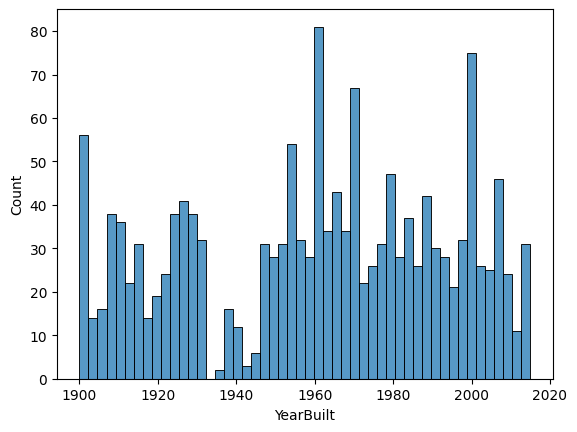

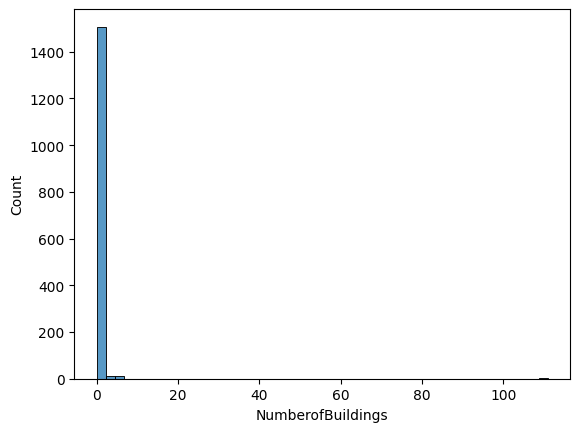

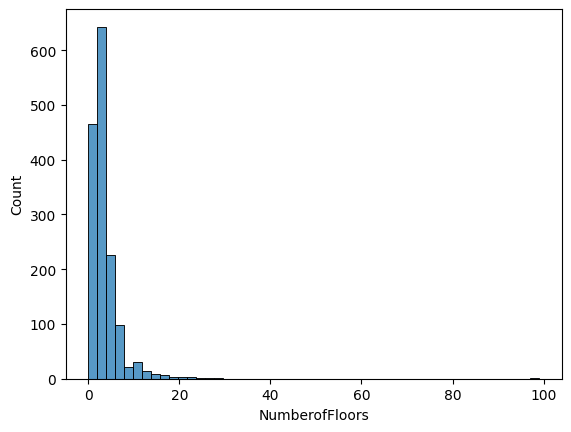

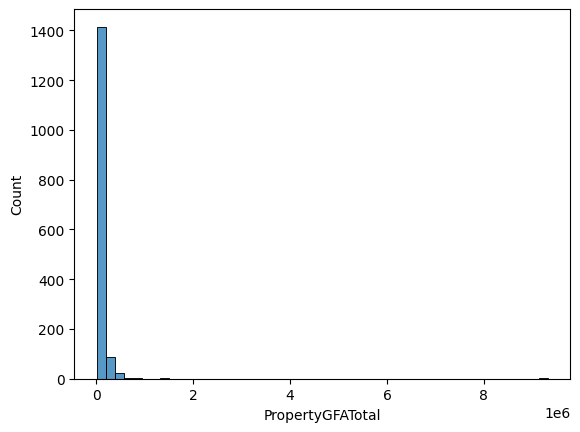

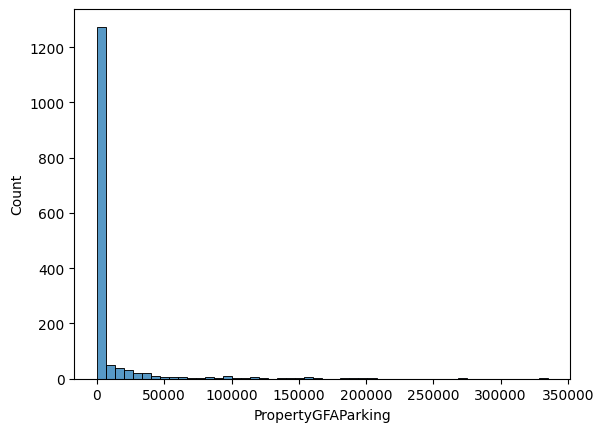

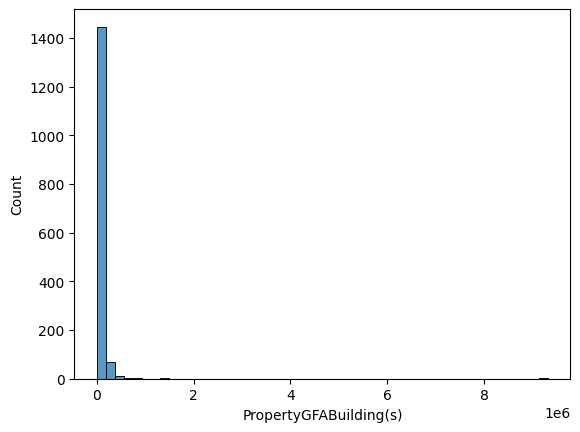

In [24]:
for col in building_columns:
    df = graphs_data[col]
    sns.histplot(df, bins = 50)
    plt.show()

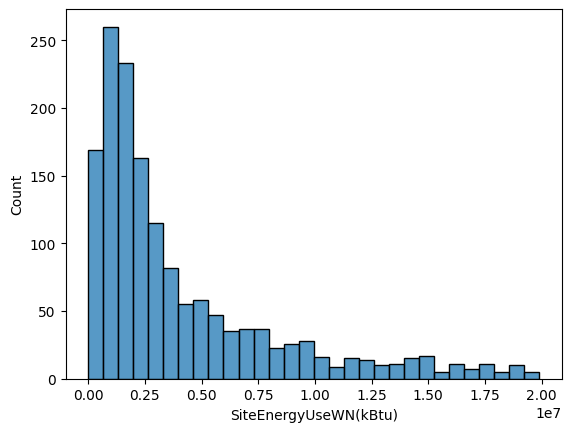

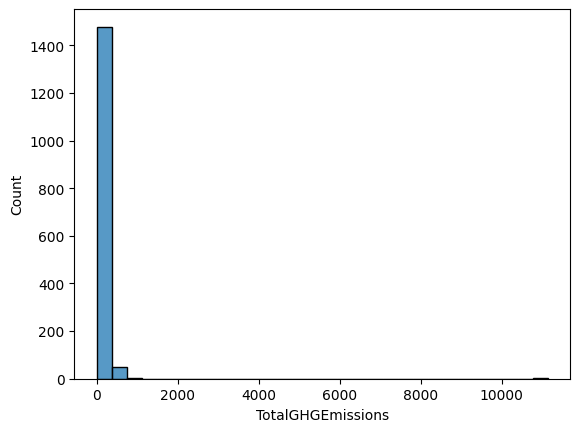

In [25]:
for col in target_columns:
    df = graphs_data[col]
    sns.histplot(df, bins = 30)
    plt.show()

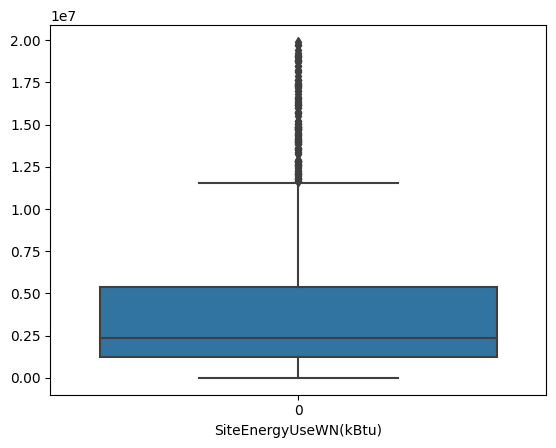

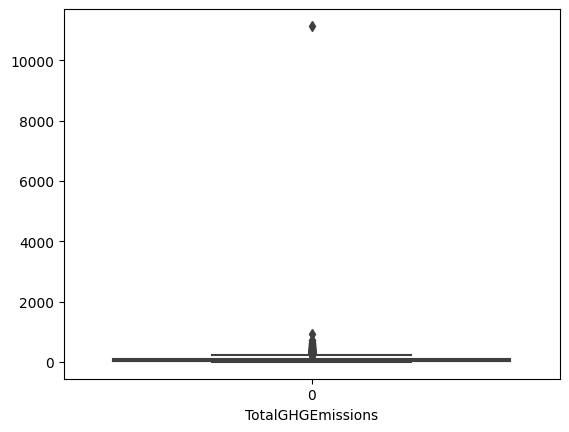

In [26]:
for col in target_columns:
    df = graphs_data[col]
    sns.boxplot(df)
    plt.xlabel(col)
    plt.show()

In [27]:
non_residential_data.loc[non_residential_data["SiteEnergyUse(kBtu)"] >
                         200000000, ["SiteEUI(kBtu/sf)"]]

SiteEUI(kBtu/sf)
35          221.699997
124         288.799988
170         217.100006
558         639.700012
618         177.899994
3274         93.800003

In [28]:
non_residential_data.loc[3274]

OSEBuildingID                                                          49967
DataYear                                                                2016
BuildingType                                                          Campus
PrimaryPropertyType                                               University
PropertyName                       University of Washington - Seattle Campus
Address                                            NE 45th St & Brooklyn Ave
City                                                                 Seattle
State                                                                     WA
ZipCode                                                              98105.0
TaxParcelIdentificationNumber                                     1625049001
CouncilDistrictCode                                                        4
Neighborhood                                                       NORTHEAST
Latitude                                                            47.65644

In [29]:
non_residential_data.isna().mean()

OSEBuildingID                      0.000000
DataYear                           0.000000
BuildingType                       0.000000
PrimaryPropertyType                0.000000
PropertyName                       0.000000
Address                            0.000000
City                               0.000000
State                              0.000000
ZipCode                            0.009592
TaxParcelIdentificationNumber      0.000000
CouncilDistrictCode                0.000000
Neighborhood                       0.000000
Latitude                           0.000000
Longitude                          0.000000
YearBuilt                          0.000000
NumberofBuildings                  0.001199
NumberofFloors                     0.000000
PropertyGFATotal                   0.000000
PropertyGFAParking                 0.000000
PropertyGFABuilding(s)             0.000000
ListOfAllPropertyUseTypes          0.001199
LargestPropertyUseType             0.003597
LargestPropertyUseTypeGFA       

In [30]:
non_residential_data = non_residential_data[~(
    non_residential_data["GHGEmissionsIntensity"].isnull())]
non_residential_data.isnull().mean()

OSEBuildingID                      0.000000
DataYear                           0.000000
BuildingType                       0.000000
PrimaryPropertyType                0.000000
PropertyName                       0.000000
Address                            0.000000
City                               0.000000
State                              0.000000
ZipCode                            0.009604
TaxParcelIdentificationNumber      0.000000
CouncilDistrictCode                0.000000
Neighborhood                       0.000000
Latitude                           0.000000
Longitude                          0.000000
YearBuilt                          0.000000
NumberofBuildings                  0.000000
NumberofFloors                     0.000000
PropertyGFATotal                   0.000000
PropertyGFAParking                 0.000000
PropertyGFABuilding(s)             0.000000
ListOfAllPropertyUseTypes          0.000000
LargestPropertyUseType             0.002401
LargestPropertyUseTypeGFA       

In [31]:
correlation_columns = [
    'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
    'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)',
    'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)',
    'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)',
    'TotalGHGEmissions', 'GHGEmissionsIntensity'
]
correlated_data = non_residential_data[correlation_columns].corr()
correlated_data

ENERGYSTARScore  SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  \
ENERGYSTARScore               1.000000         -0.350665           -0.355019   
SiteEUI(kBtu/sf)             -0.350665          1.000000            0.993084   
SiteEUIWN(kBtu/sf)           -0.355019          0.993084            1.000000   
SourceEUI(kBtu/sf)           -0.297920          0.947907            0.934756   
SourceEUIWN(kBtu/sf)         -0.300041          0.943962            0.943204   
SiteEnergyUse(kBtu)          -0.080135          0.272841            0.243171   
SiteEnergyUseWN(kBtu)        -0.079498          0.367244            0.364939   
SteamUse(kBtu)               -0.039023          0.090905            0.076598   
Electricity(kWh)             -0.028411          0.259684            0.226092   
Electricity(kBtu)            -0.028411          0.259684            0.226092   
NaturalGas(therms)           -0.117790          0.235456            0.238702   
NaturalGas(kBtu)             -0.117790          0.235456            0.238702   
TotalGHGEmissions            -0.108145          0.257353            0.244926   
GHGEmissionsIntensity        -0.297997          0.711139            0.725336   

                       SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
ENERGYSTARScore                 -0.297920             -0.300041   
SiteEUI(kBtu/sf)                 0.947907              0.943962   
SiteEUIWN(kBtu/sf)               0.934756              0.943204   
SourceEUI(kBtu/sf)               1.000000              0.994005   
SourceEUIWN(kBtu/sf)             0.994005              1.000000   
SiteEnergyUse(kBtu)              0.270029              0.241311   
SiteEnergyUseWN(kBtu)            0.359801              0.359604   
SteamUse(kBtu)                   0.075107              0.060813   
Electricity(kWh)                 0.297760              0.266753   
Electricity(kBtu)                0.297760              0.266753   
NaturalGas(therms)               0.156777              0.157061   
NaturalGas(kBtu)                 0.156777              0.157061   
TotalGHGEmissions                0.203679              0.189798   
GHGEmissionsIntensity            0.513501              0.520236   

                       SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  \
ENERGYSTARScore                  -0.080135              -0.079498   
SiteEUI(kBtu/sf)                  0.272841               0.367244   
SiteEUIWN(kBtu/sf)                0.243171               0.364939   
SourceEUI(kBtu/sf)                0.270029               0.359801   
SourceEUIWN(kBtu/sf)              0.241311               0.359604   
SiteEnergyUse(kBtu)               1.000000               0.704050   
SiteEnergyUseWN(kBtu)             0.704050               1.000000   
SteamUse(kBtu)                    0.605002               0.471165   
Electricity(kWh)                  0.956264               0.573420   
Electricity(kBtu)                 0.956264               0.573420   
NaturalGas(therms)                0.503369               0.723368   
NaturalGas(kBtu)                  0.503369               0.723368   
TotalGHGEmissions                 0.859940               0.855982   
GHGEmissionsIntensity             0.298053               0.427189   

                       SteamUse(kBtu)  Electricity(kWh)  Electricity(kBtu)  \
ENERGYSTARScore             -0.039023         -0.028411          -0.028411   
SiteEUI(kBtu/sf)             0.090905          0.259684           0.259684   
SiteEUIWN(kBtu/sf)           0.076598          0.226092           0.226092   
SourceEUI(kBtu/sf)           0.075107          0.297760           0.297760   
SourceEUIWN(kBtu/sf)         0.060813          0.266753           0.266753   
SiteEnergyUse(kBtu)          0.605002          0.956264           0.956264   
SiteEnergyUseWN(kBtu)        0.471165          0.573420           0.573420   
SteamUse(kBtu)               1.000000          0.547671           0.547671   
Electricity(kWh)             0.547671          1.000000           1.000000   


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5]),
 [Text(0.5, 0, 'ENERGYSTARScore'),
  Text(1.5, 0, 'SiteEUI(kBtu/sf)'),
  Text(2.5, 0, 'SiteEUIWN(kBtu/sf)'),
  Text(3.5, 0, 'SourceEUI(kBtu/sf)'),
  Text(4.5, 0, 'SourceEUIWN(kBtu/sf)'),
  Text(5.5, 0, 'SiteEnergyUse(kBtu)'),
  Text(6.5, 0, 'SiteEnergyUseWN(kBtu)'),
  Text(7.5, 0, 'SteamUse(kBtu)'),
  Text(8.5, 0, 'Electricity(kWh)'),
  Text(9.5, 0, 'Electricity(kBtu)'),
  Text(10.5, 0, 'NaturalGas(therms)'),
  Text(11.5, 0, 'NaturalGas(kBtu)'),
  Text(12.5, 0, 'TotalGHGEmissions'),
  Text(13.5, 0, 'GHGEmissionsIntensity')])

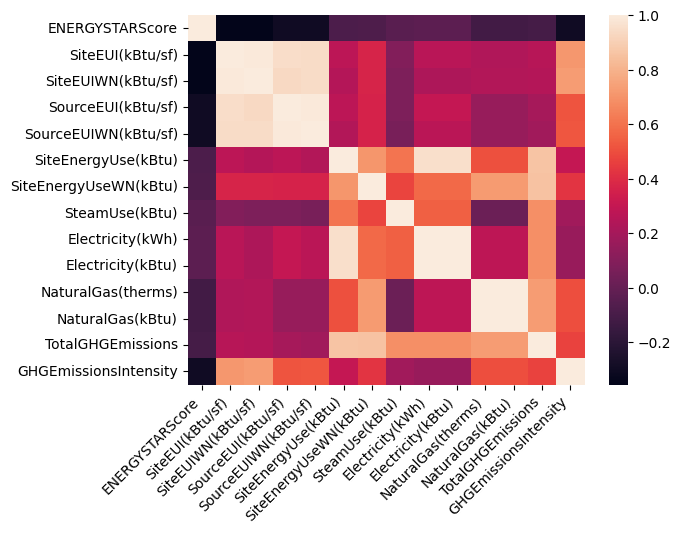

In [32]:
sns.heatmap(correlated_data)
plt.xticks(rotation=45, ha="right")

In [33]:
non_residential_data.loc[
    non_residential_data["LargestPropertyUseType"].isnull(), [
        "ListOfAllPropertyUseTypes", "PropertyGFATotal", "PropertyGFAParking",
        "PropertyGFABuilding(s)", "LargestPropertyUseType",
        "LargestPropertyUseTypeGFA", "SecondLargestPropertyUseType",
        "SecondLargestPropertyUseTypeGFA", "ThirdLargestPropertyUseType",
        "ThirdLargestPropertyUseTypeGFA"
    ]]

ListOfAllPropertyUseTypes  PropertyGFATotal  \
353   Fitness Center/Health Club/Gym, Office, Other ...            111445   
1147                                              Hotel             61721   
2414                                             Office             48350   
2459                                         Restaurant             28800   

      PropertyGFAParking  PropertyGFABuilding(s) LargestPropertyUseType  \
353                    0                  111445                    NaN   
1147                   0                   61721                    NaN   
2414                   0                   48350                    NaN   
2459                   0                   28800                    NaN   

      LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
353                         NaN                          NaN   
1147                        NaN                          NaN   
2414                        NaN                          NaN   
2459                        NaN                          NaN   

      SecondLargestPropertyUseTypeGFA ThirdLargestPropertyUseType  \
353                               NaN                         NaN   
1147                              NaN                         NaN   
2414                              NaN                         NaN   
2459                              NaN                         NaN   

      ThirdLargestPropertyUseTypeGFA  
353                              NaN  
1147                             NaN  
2414                             NaN  
2459                             NaN

In [34]:
secondary_gfa_proportion = (
    non_residential_data["SecondLargestPropertyUseTypeGFA"] /
    non_residential_data["PropertyGFABuilding(s)"]).mean()
secondary_gfa_proportion

0.28593365392719905

In [35]:
third_gfa_proportion = (
    non_residential_data["ThirdLargestPropertyUseTypeGFA"] /
    non_residential_data["PropertyGFABuilding(s)"]).mean()
third_gfa_proportion

0.11748484664685344

In [36]:
non_residential_data = non_residential_data.apply(
    lambda r: property_use_type_fill(r), axis=1)

# Test Fonctions

In [37]:
test_func = data.copy()
test_func.shape

(3376, 46)

In [38]:
func_data = keep_columns(test_func)
func_data.shape

(3376, 22)

In [39]:
func_data = keep_building_types(func_data)
func_data.shape

(1668, 22)

In [40]:
func_data = drop_missing_values_energy_use(func_data)
func_data.shape

(1666, 22)

In [41]:
func_data = fill_df_property_use_type(func_data)
func_data.shape

(1666, 22)

In [42]:
func_data = fill_nan_largest_property_use_type(func_data)
func_data.shape

(1666, 22)

In [43]:
func_data.isnull().mean()

YearBuilt                          0.000000
NumberofBuildings                  0.000000
NumberofFloors                     0.000000
PropertyGFATotal                   0.000000
PropertyGFAParking                 0.000000
PropertyGFABuilding(s)             0.000000
BuildingType                       0.000000
PrimaryPropertyType                0.000000
ListOfAllPropertyUseTypes          0.000000
LargestPropertyUseType             0.000000
SecondLargestPropertyUseType       0.000000
ThirdLargestPropertyUseType        0.000000
LargestPropertyUseTypeGFA          0.000000
SecondLargestPropertyUseTypeGFA    0.000000
ThirdLargestPropertyUseTypeGFA     0.000000
SteamUse(kBtu)                     0.000000
Electricity(kBtu)                  0.000000
NaturalGas(kBtu)                   0.000000
SiteEnergyUse(kBtu)                0.000000
SiteEUI(kBtu/sf)                   0.000600
ENERGYSTARScore                    0.343337
TotalGHGEmissions                  0.000000
dtype: float64

# Pipeline

In [44]:
# Création des transformer

# Tri des colonnes à garder
keep_columns_transformer = FunctionTransformer(keep_columns)

# Tri des Building Types
keep_building_types_transformer = FunctionTransformer(keep_building_types)

# Suppression des lignes sans valeur pour les émissions de CO2
drop_missing_emissions_transformer = FunctionTransformer(drop_missing_values_energy_use)

# remplissage des colonnes Largest Property Use Type
fill_largest_property_use_type_transformer = FunctionTransformer(fill_df_property_use_type)

# remplissage du reste des valeurs manquantes
fill_nan_property_use_type_transformer = FunctionTransformer(fill_nan_largest_property_use_type)

In [45]:
complete_pipeline = Pipeline([
    ("keep_columns", keep_columns_transformer),
    ("keep_buildings_types", keep_building_types_transformer),
    ("drop_missing_values_emissions", drop_missing_emissions_transformer),
    ("fill_largest_property_use_type",
     fill_largest_property_use_type_transformer),
    ("fill_nan_property_use_type", fill_nan_property_use_type_transformer)
])

In [46]:
test_data=data.copy()

In [47]:
transformed_data = complete_pipeline.fit_transform(test_data)

In [48]:
transformed_data.shape

(1666, 22)

In [49]:
transformed_data.isnull().mean()

YearBuilt                          0.000000
NumberofBuildings                  0.000000
NumberofFloors                     0.000000
PropertyGFATotal                   0.000000
PropertyGFAParking                 0.000000
PropertyGFABuilding(s)             0.000000
BuildingType                       0.000000
PrimaryPropertyType                0.000000
ListOfAllPropertyUseTypes          0.000000
LargestPropertyUseType             0.000000
SecondLargestPropertyUseType       0.000000
ThirdLargestPropertyUseType        0.000000
LargestPropertyUseTypeGFA          0.000000
SecondLargestPropertyUseTypeGFA    0.000000
ThirdLargestPropertyUseTypeGFA     0.000000
SteamUse(kBtu)                     0.000000
Electricity(kBtu)                  0.000000
NaturalGas(kBtu)                   0.000000
SiteEnergyUse(kBtu)                0.000000
SiteEUI(kBtu/sf)                   0.000600
ENERGYSTARScore                    0.343337
TotalGHGEmissions                  0.000000
dtype: float64

# Graphiques

In [50]:
graphs_data = transformed_data.copy()
graphs_data.shape

(1666, 22)

In [51]:
# création de listes de colonnes pour les graphiques

# Toutes les colonnes
all_columns = list(graphs_data.columns)

# Colonnes GFA
columns_gfa = [
    "PropertyGFATotal", "PropertyGFABuilding(s)", "PropertyGFAParking",
    "LargestPropertyUseTypeGFA", "SecondLargestPropertyUseTypeGFA",
    "ThirdLargestPropertyUseTypeGFA"
]

# Colonnes d'energies
columns_energy = ["SteamUse(kBtu)", "Electricity(kBtu)", "NaturalGas(kBtu)"]



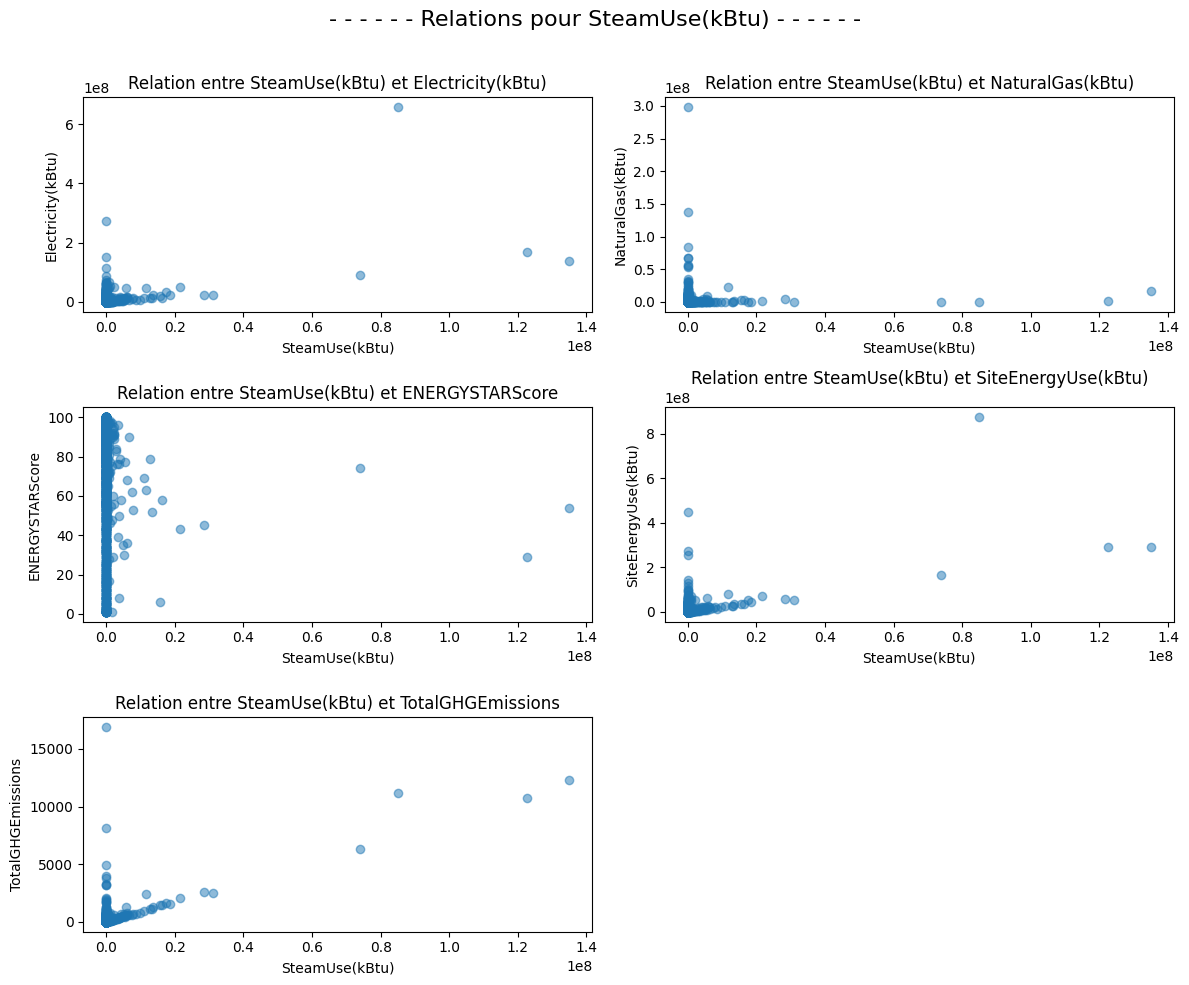

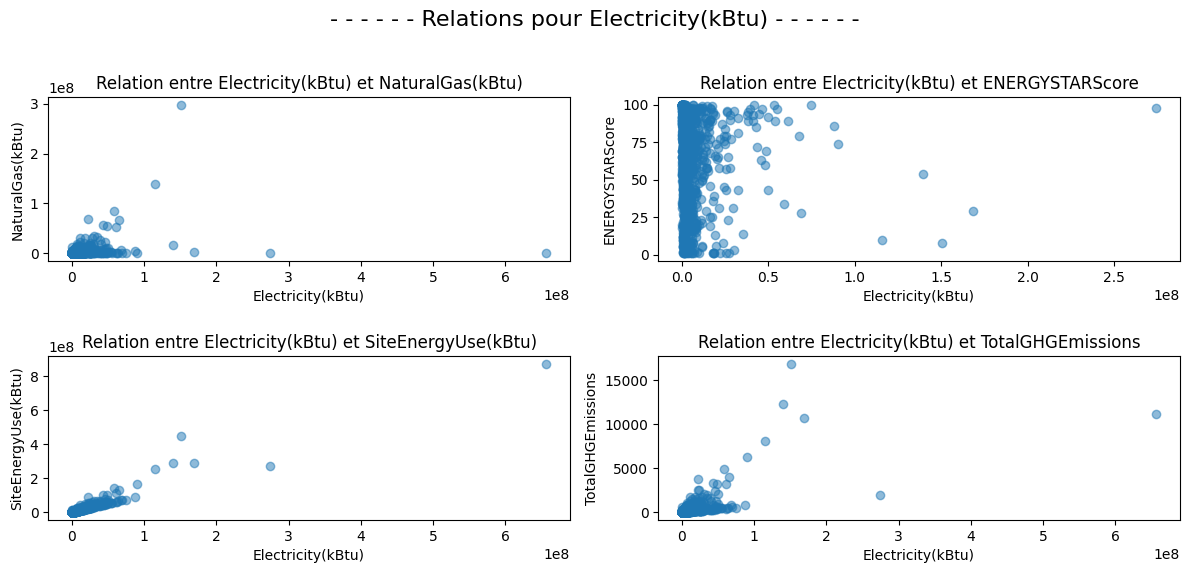

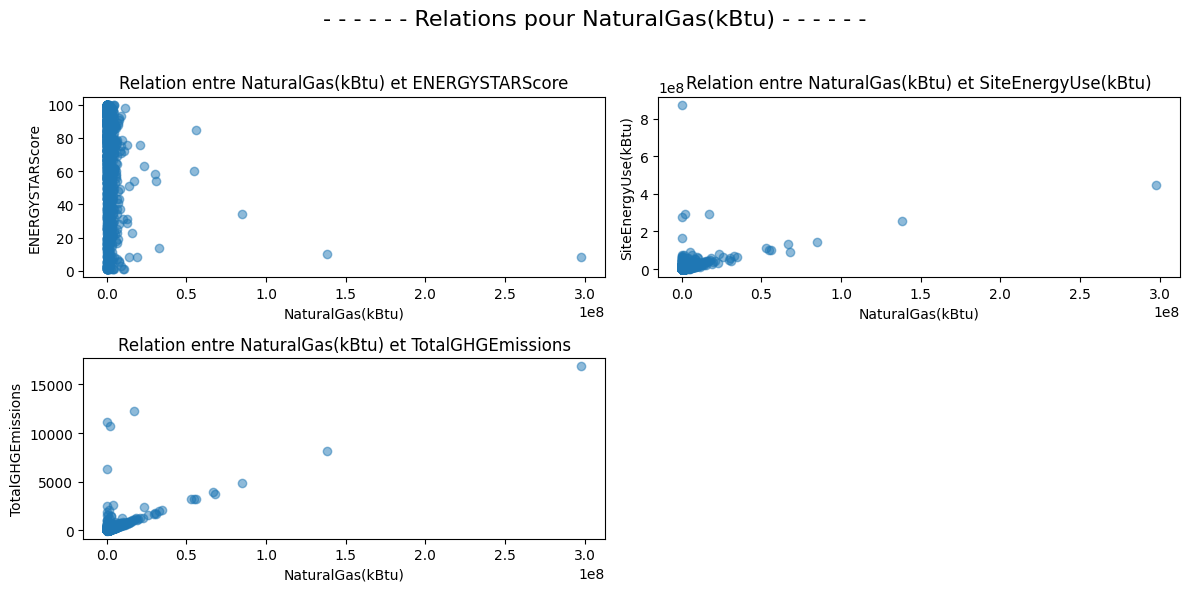

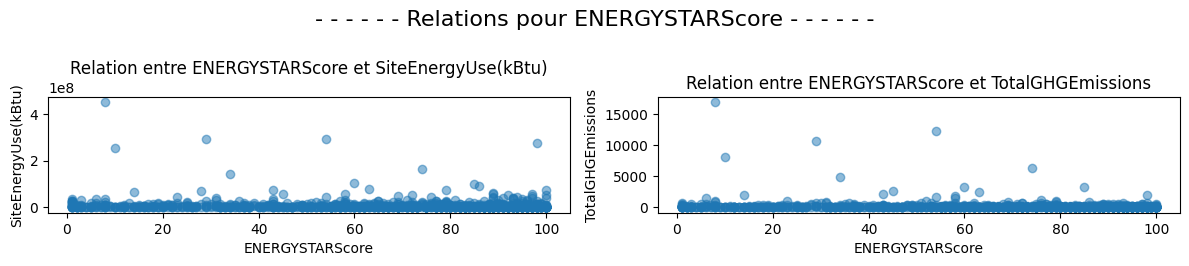

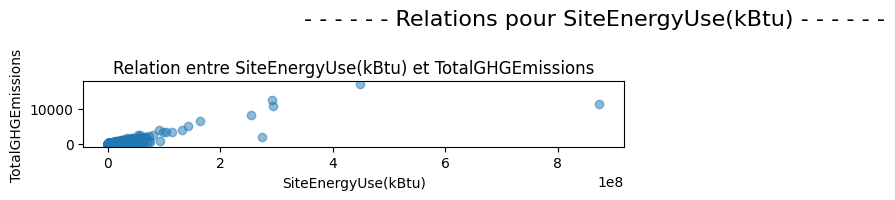

<Figure size 1200x0 with 0 Axes>

In [52]:
numeric_data = graphs_data[['SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)',
       'ENERGYSTARScore', 'SiteEnergyUse(kBtu)', 'TotalGHGEmissions']]
numeric_col = numeric_data.columns

for i, col_x in enumerate(numeric_col):
    nb_graphs = len(numeric_col) - (i + 1)

    plt.figure(figsize=(12, nb_graphs * 2))
    nb_sub = 1
    plt.suptitle(f"- - - - - - Relations pour {col_x} - - - - - -",
                 fontsize=16)

    for j in range(i + 1, len(numeric_col)):

        col_y = numeric_col[j]
        plt.subplot(nb_graphs // 2 + 1, 2, nb_sub)
        plt.scatter(numeric_data[col_x], numeric_data[col_y], alpha=0.5)
        plt.title(f"Relation entre {col_x} et {col_y}")
        plt.xlabel(col_x)
        plt.ylabel(col_y)

        nb_sub += 1

    plt.tight_layout(rect=(0, 0, 1, 0.98))
plt.show()

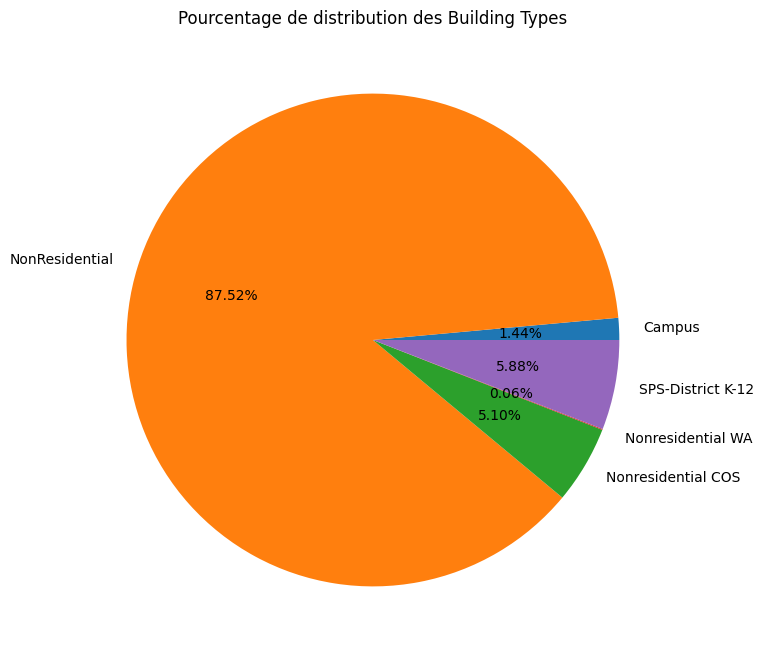

In [53]:
grouped_data = graphs_data.groupby("BuildingType")["YearBuilt"].count()
grouped_data.name = "Count"

plt.figure(figsize=(12,8))

plt.pie(grouped_data, labels=grouped_data.index, autopct="%.2f%%")

plt.title("Pourcentage de distribution des Building Types")

plt.show()

In [54]:
all_columns

['YearBuilt',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'PropertyGFAParking',
 'PropertyGFABuilding(s)',
 'BuildingType',
 'PrimaryPropertyType',
 'ListOfAllPropertyUseTypes',
 'LargestPropertyUseType',
 'SecondLargestPropertyUseType',
 'ThirdLargestPropertyUseType',
 'LargestPropertyUseTypeGFA',
 'SecondLargestPropertyUseTypeGFA',
 'ThirdLargestPropertyUseTypeGFA',
 'SteamUse(kBtu)',
 'Electricity(kBtu)',
 'NaturalGas(kBtu)',
 'SiteEnergyUse(kBtu)',
 'SiteEUI(kBtu/sf)',
 'ENERGYSTARScore',
 'TotalGHGEmissions']

# ACP

In [55]:
columns_acp = [
    'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
    'LargestPropertyUseTypeGFA', 'SteamUse(kBtu)', 'Electricity(kBtu)',
    'NaturalGas(kBtu)', 'BuildingType', "PrimaryPropertyType",
    "LargestPropertyUseType"
]

In [56]:
scaler_columns = [
    'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
    'LargestPropertyUseTypeGFA', 'SteamUse(kBtu)', 'Electricity(kBtu)',
    'NaturalGas(kBtu)'
]

encoder_columns = [
    'BuildingType', "PrimaryPropertyType", "LargestPropertyUseType"
]

# Nombre des composantes à trouver
n_components = len(columns_acp)

In [57]:
dropna_lines_transformer = FunctionTransformer(dropna_lignes,
                                               kw_args={"subset": columns_acp})

columns_transformer = make_column_transformer(
    (StandardScaler(), scaler_columns), (OneHotEncoder(), encoder_columns),
    remainder="drop")

acp_pipeline = make_pipeline(complete_pipeline, dropna_lines_transformer,
                             columns_transformer,
                             TruncatedSVD(n_components=n_components))

In [58]:
acp_data = data.copy()

In [59]:
acp_pipeline.fit(acp_data)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('keep_columns',
                                  FunctionTransformer(func=<function keep_columns at 0x00000237FBC7E2A0>)),
                                 ('keep_buildings_types',
                                  FunctionTransformer(func=<function keep_building_types at 0x00000237FBC7E660>)),
                                 ('drop_missing_values_emissions',
                                  FunctionTransformer(func=<function drop_missing_values_energy_use at 0x00000237FBC7E700>)...
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['PropertyGFATotal',
                                                   'PropertyGFAParking',
                                                   'PropertyGFABuilding(s)',
                                                   'LargestPropertyUseTypeGFA',
                                                   'SteamUse(kBtu)',
                                                   'Electricity(kBtu)',
                                                   'NaturalGas(kBtu)']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['BuildingType',
                                                   'PrimaryPropertyType',
                                                   'LargestPropertyUseType'])])),
                ('truncatedsvd', TruncatedSVD(n_components=10))])

In [60]:
truncatedsvd = acp_pipeline["truncatedsvd"]

In [61]:
# Visualisation des varainces exprimées par chaque composante
truncatedsvd.explained_variance_ratio_

array([0.47124961, 0.04457014, 0.10320294, 0.09617616, 0.06583001,
       0.03395558, 0.02242083, 0.02258742, 0.0167562 , 0.01599363])

In [62]:
# Récupération de ces variances
scree = (truncatedsvd.explained_variance_ratio_ * 100).round(2)
scree

array([47.12,  4.46, 10.32,  9.62,  6.58,  3.4 ,  2.24,  2.26,  1.68,
        1.6 ])

In [63]:
# Calcul du cumul des vraince
scree_cum = scree.cumsum().round()
scree_cum

array([47., 52., 62., 72., 78., 82., 84., 86., 88., 89.])

In [64]:
# création d'un range en fonction du nombre de composantes pour les graphiques
x_list = range(1, n_components+1)
list(x_list)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

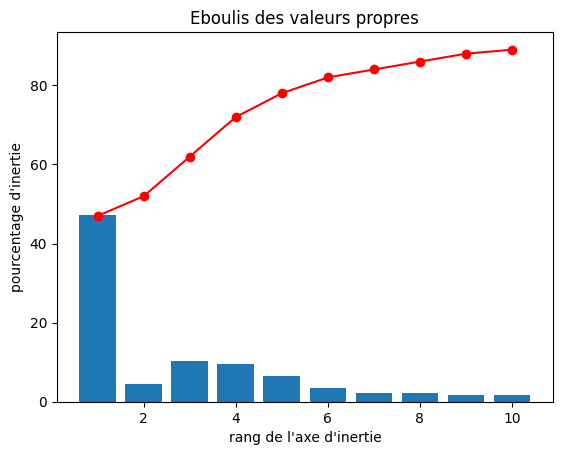

In [65]:
# Affchage des variances et de leur cumul
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum, c="red", marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

In [66]:
# récupération de toute les composantes
pcs = truncatedsvd.components_
pcs = pd.DataFrame(pcs)
pcs

0         1         2         3         4         5         6   \
0  0.473328  0.161676  0.471177  0.474897  0.286740  0.451682  0.113138   
1 -0.055371 -0.372849 -0.002475 -0.000394  0.122127  0.052887  0.217286   
2 -0.076500 -0.713721  0.026120  0.018818  0.506141  0.069517 -0.329706   
3 -0.078701 -0.289001 -0.039356 -0.034792 -0.086318  0.109929  0.874192   
4 -0.190697  0.445890 -0.265840 -0.187366  0.777510 -0.033969  0.199010   
5 -0.022944 -0.080057 -0.012098 -0.029522  0.029278  0.035886  0.021952   
6 -0.030033 -0.023154 -0.027978 -0.048475 -0.042143  0.145363 -0.023878   
7 -0.052093 -0.020173 -0.051503 -0.047574 -0.066011  0.209057 -0.068573   
8 -0.065277  0.041596 -0.074484 -0.027789 -0.009759  0.186380 -0.018057   
9 -0.225229  0.060617 -0.244664 -0.189538 -0.139889  0.801382 -0.132533   

         7         8         9   ...        80        81        82        83  \
0  0.014113 -0.010429 -0.002377  ... -0.000954 -0.004484 -0.001930  0.000179   
1  0.006787 -0.756372 -0.005029  ... -0.003814 -0.038348 -0.010342 -0.006976   
2 -0.002998  0.284549  0.008748  ...  0.002651  0.028834  0.007457  0.001239   
3  0.028984  0.311480  0.004008  ...  0.004752  0.021962  0.004021  0.009057   
4 -0.013278  0.001008 -0.004146  ...  0.000365 -0.014551 -0.002142 -0.000432   
5 -0.001246 -0.265582 -0.016211  ... -0.005569 -0.070715 -0.014357 -0.010750   
6 -0.015035 -0.028336 -0.004722  ... -0.000671 -0.011629 -0.002795 -0.002841   
7  0.009820  0.089193  0.125783  ...  0.003700  0.064076  0.008436  0.003383   
8  0.019938 -0.200660  0.231058  ... -0.010874 -0.306343 -0.030116 -0.020926   
9 -0.009098  0.041859 -0.121896  ...  0.003761  0.068054 -0.001385 -0.006273   

         84        85        86        87        88        89  
0 -0.000799 -0.000165 -0.001928  0.000091  0.000029 -0.006034  
1 -0.003983 -0.002183 -0.015076 -0.001287 -0.000330 -0.027167  
2  0.002874  0.001597  0.007294  0.001329  0.000256  0.022080  
3  0.002267  0.002100  0.013407  0.001824  0.000326  0.014097  
4  0.000352 -0.000800  0.001482  0.000752 -0.000277 -0.003969  
5 -0.008067 -0.004837 -0.022407 -0.003182 -0.000505 -0.044631  
6 -0.002226 -0.001244 -0.000117 -0.000056 -0.000010 -0.008253  
7  0.017531  0.010792  0.019451  0.009570  0.000406  0.034413  
8  0.007065  0.004595 -0.040777  0.006486 -0.000933 -0.137243  
9 -0.005815 -0.003483  0.045985  0.004983  0.000639  0.014919  

[10 rows x 90 columns]

In [67]:
pcs.index=columns_acp

In [68]:
# Transposée du DataFrame
pcs.T

PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
0           0.473328           -0.055371               -0.076500   
1           0.161676           -0.372849               -0.713721   
2           0.471177           -0.002475                0.026120   
3           0.474897           -0.000394                0.018818   
4           0.286740            0.122127                0.506141   
..               ...                 ...                     ...   
85         -0.000165           -0.002183                0.001597   
86         -0.001928           -0.015076                0.007294   
87          0.000091           -0.001287                0.001329   
88          0.000029           -0.000330                0.000256   
89         -0.006034           -0.027167                0.022080   

    LargestPropertyUseTypeGFA  SteamUse(kBtu)  Electricity(kBtu)  \
0                   -0.078701       -0.190697          -0.022944   
1                   -0.289001        0.445890          -0.080057   
2                   -0.039356       -0.265840          -0.012098   
3                   -0.034792       -0.187366          -0.029522   
4                   -0.086318        0.777510           0.029278   
..                        ...             ...                ...   
85                   0.002100       -0.000800          -0.004837   
86                   0.013407        0.001482          -0.022407   
87                   0.001824        0.000752          -0.003182   
88                   0.000326       -0.000277          -0.000505   
89                   0.014097       -0.003969          -0.044631   

    NaturalGas(kBtu)  BuildingType  PrimaryPropertyType  \
0          -0.030033     -0.052093            -0.065277   
1          -0.023154     -0.020173             0.041596   
2          -0.027978     -0.051503            -0.074484   
3          -0.048475     -0.047574            -0.027789   
4          -0.042143     -0.066011            -0.009759   
..               ...           ...                  ...   
85         -0.001244      0.010792             0.004595   
86         -0.000117      0.019451            -0.040777   
87         -0.000056      0.009570             0.006486   
88         -0.000010      0.000406            -0.000933   
89         -0.008253      0.034413            -0.137243   

    LargestPropertyUseType  
0                -0.225229  
1                 0.060617  
2                -0.244664  
3                -0.189538  
4                -0.139889  
..                     ...  
85               -0.003483  
86                0.045985  
87                0.004983  
88                0.000639  
89                0.014919  

[90 rows x 10 columns]

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 [Text(0.5, 0, 'PropertyGFATotal'),
  Text(1.5, 0, 'PropertyGFAParking'),
  Text(2.5, 0, 'PropertyGFABuilding(s)'),
  Text(3.5, 0, 'LargestPropertyUseTypeGFA'),
  Text(4.5, 0, 'SteamUse(kBtu)'),
  Text(5.5, 0, 'Electricity(kBtu)'),
  Text(6.5, 0, 'NaturalGas(kBtu)'),
  Text(7.5, 0, 'BuildingType'),
  Text(8.5, 0, 'PrimaryPropertyType'),
  Text(9.5, 0, 'LargestPropertyUseType')])

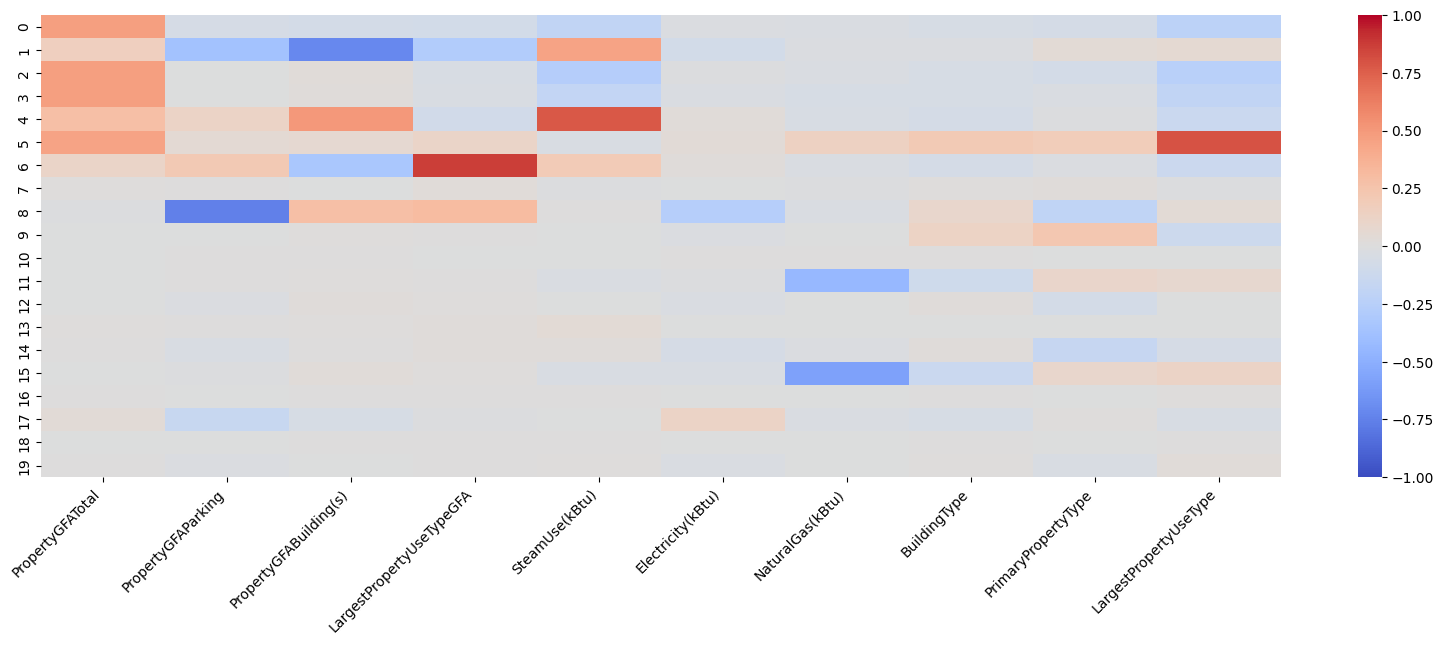

In [69]:
# Affichage de la heatmap des composantes principales
fig, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(pcs.T.iloc[:20], vmin=-1, vmax=1, annot=False, cmap="coolwarm", fmt="0.2f")
plt.xticks(rotation=45, ha="right")

In [70]:
x, y = 0, 1
x_y = (0, 1)

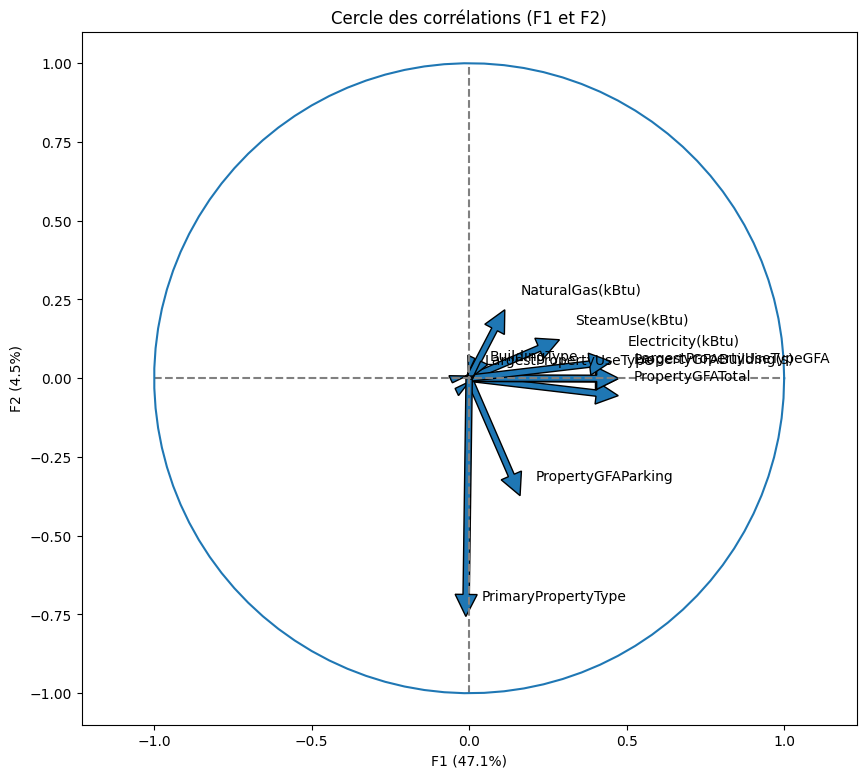

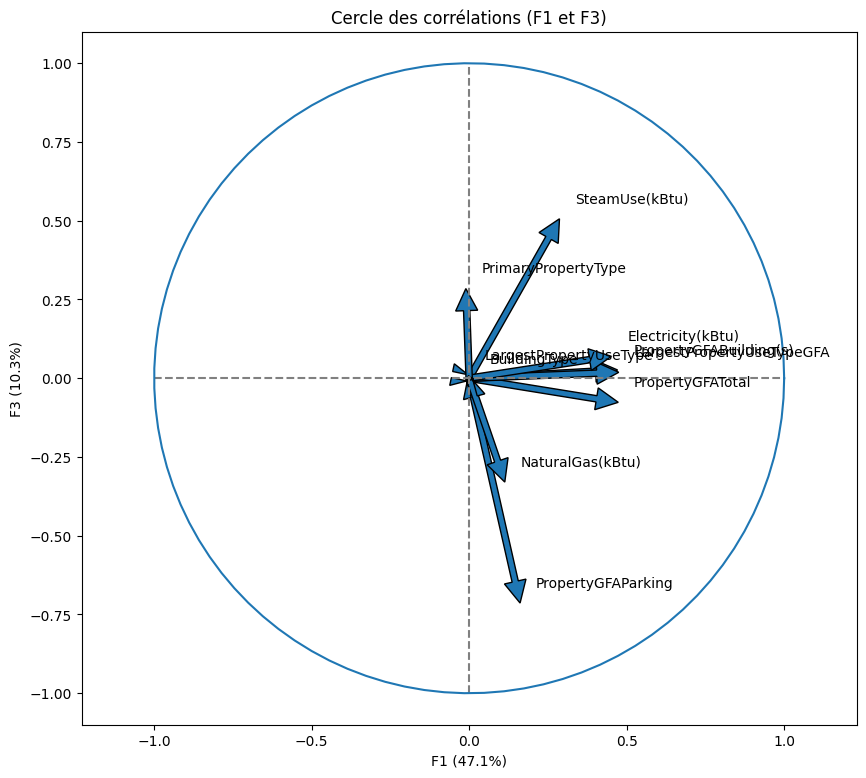

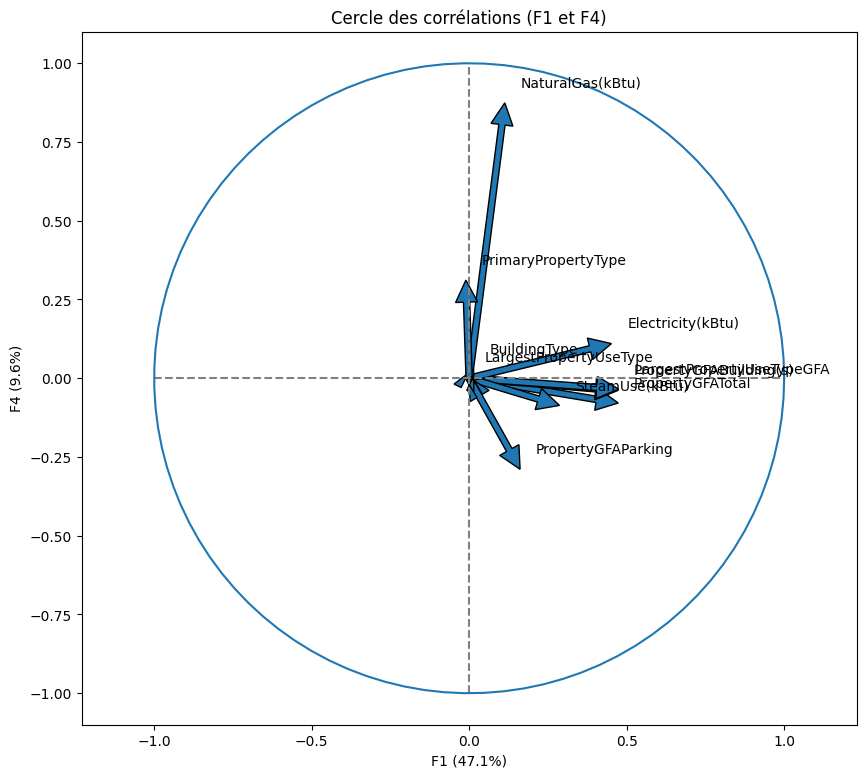

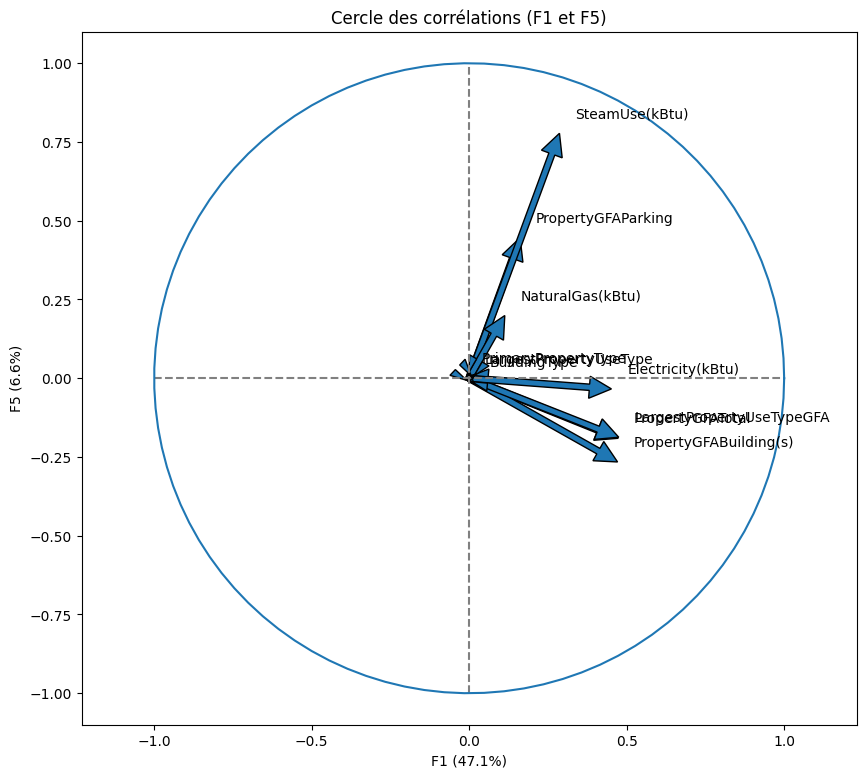

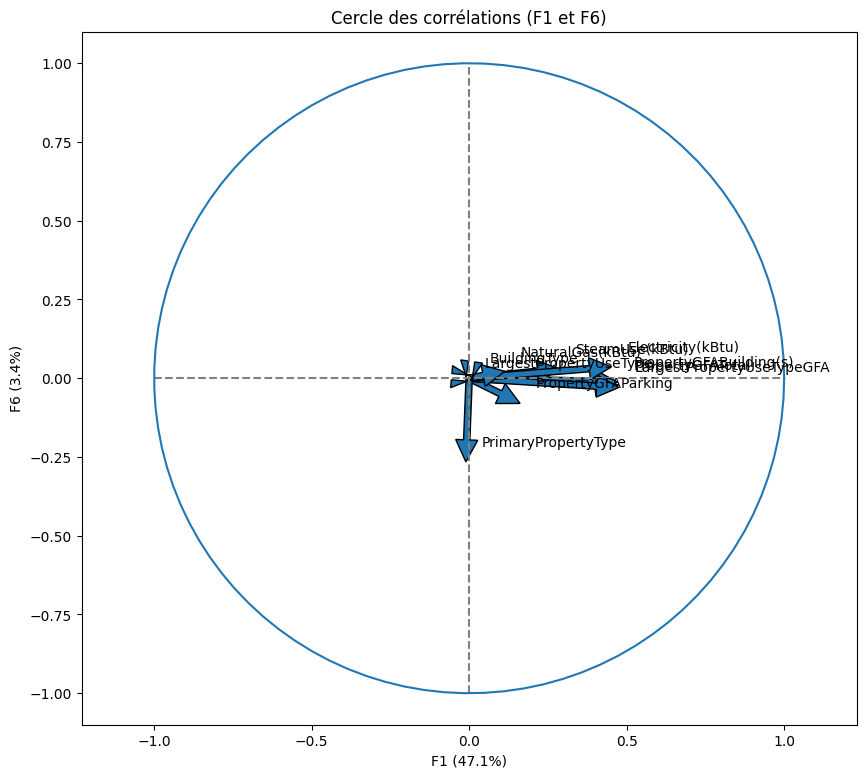

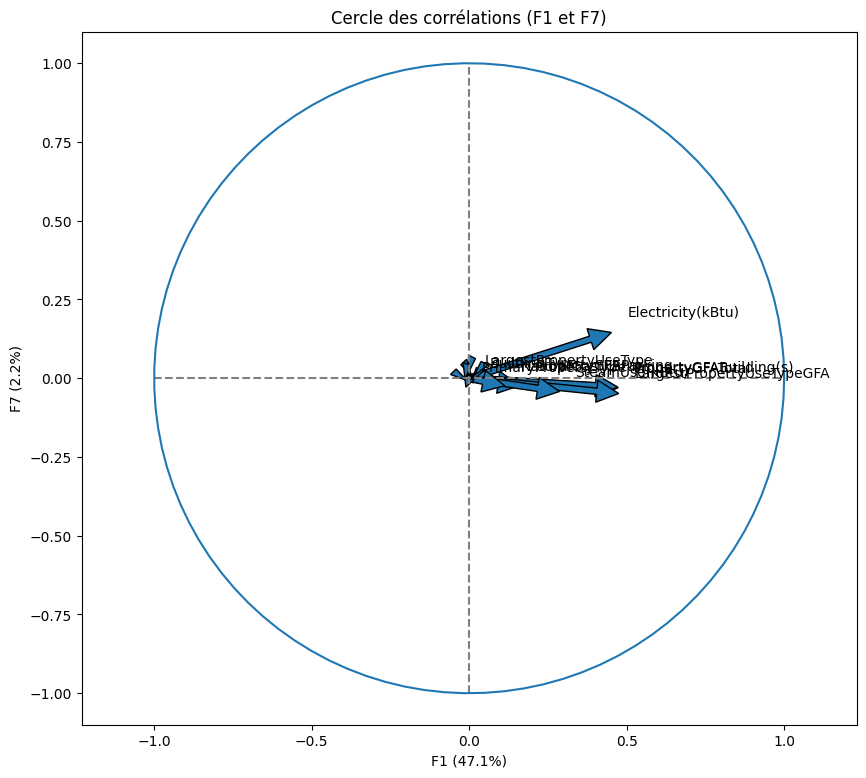

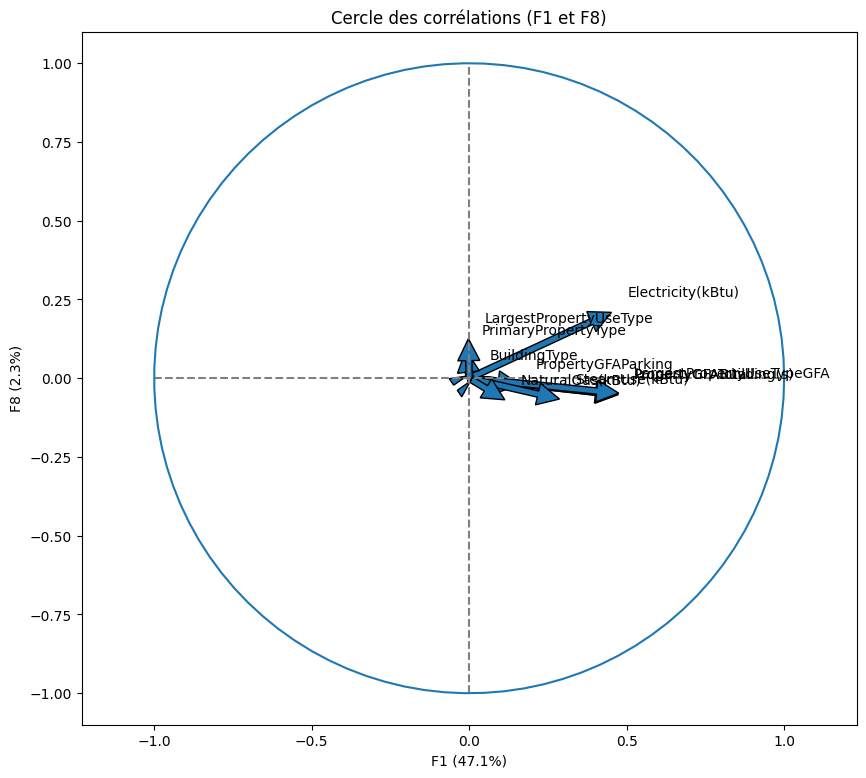

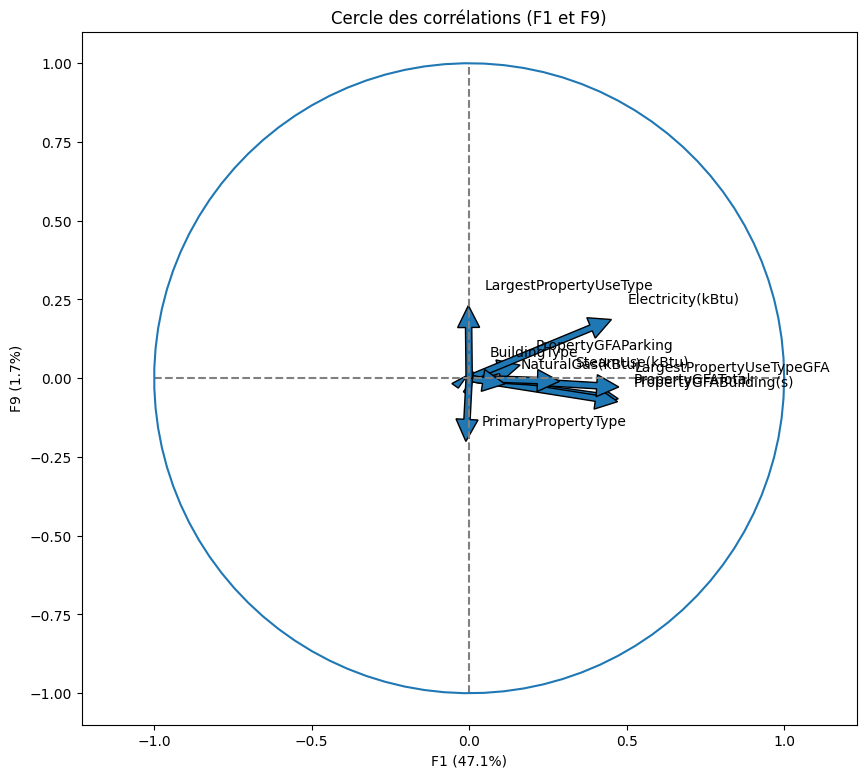

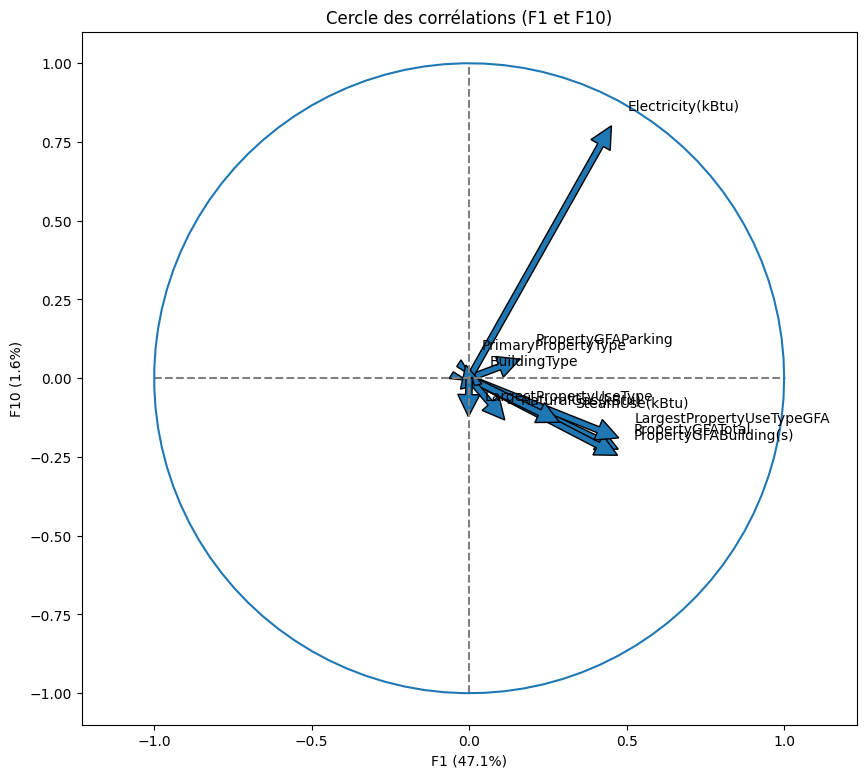

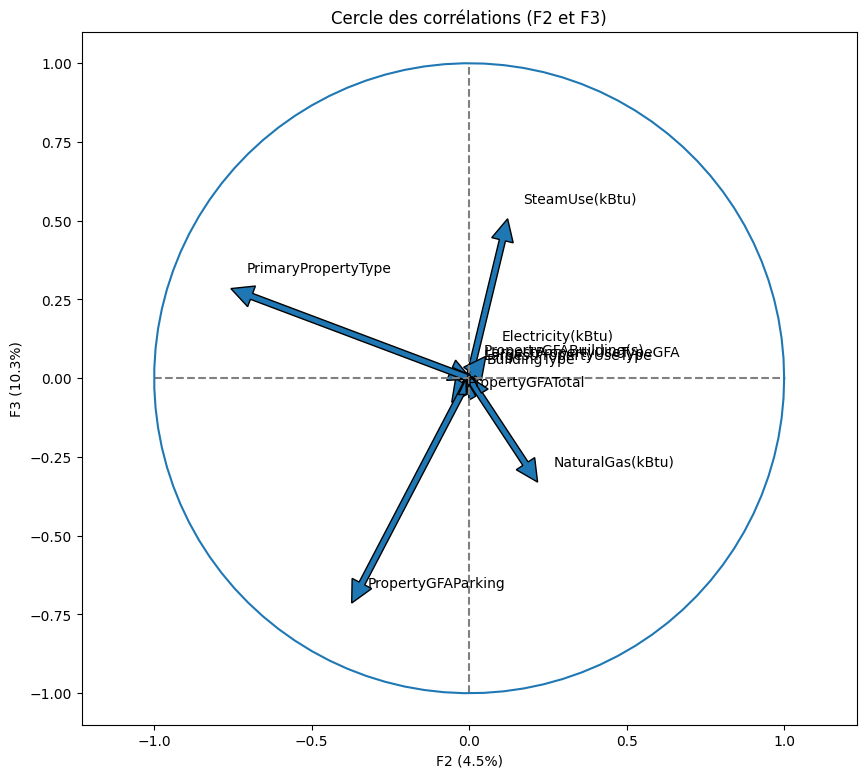

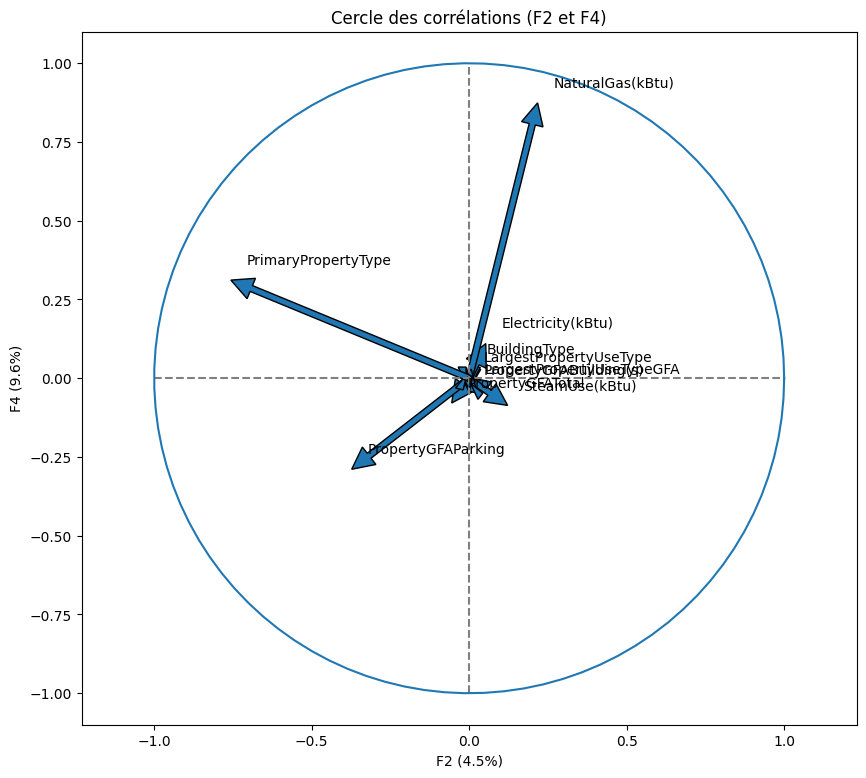

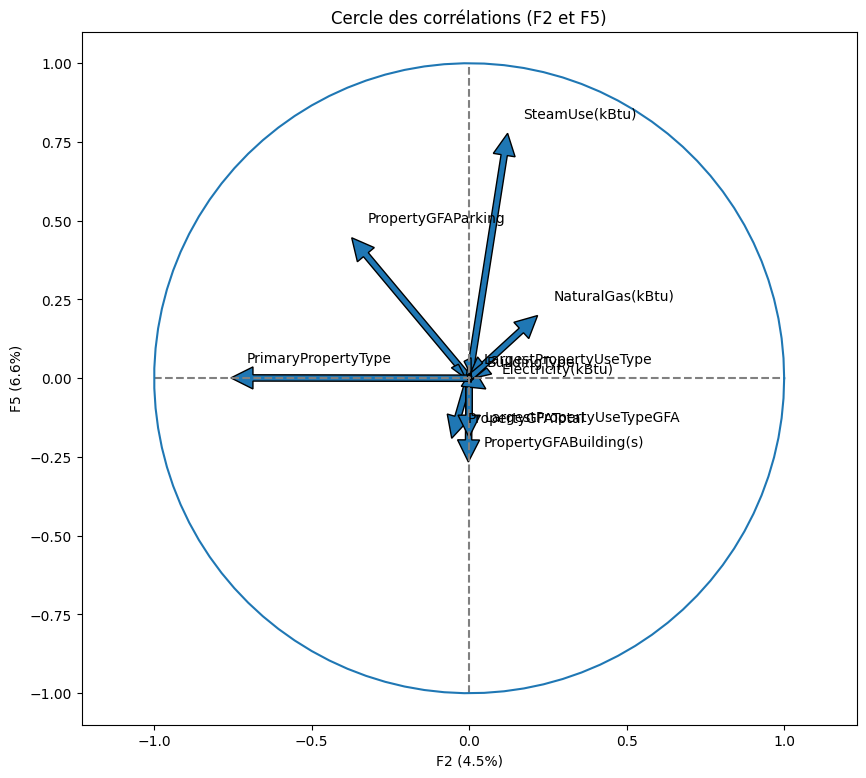

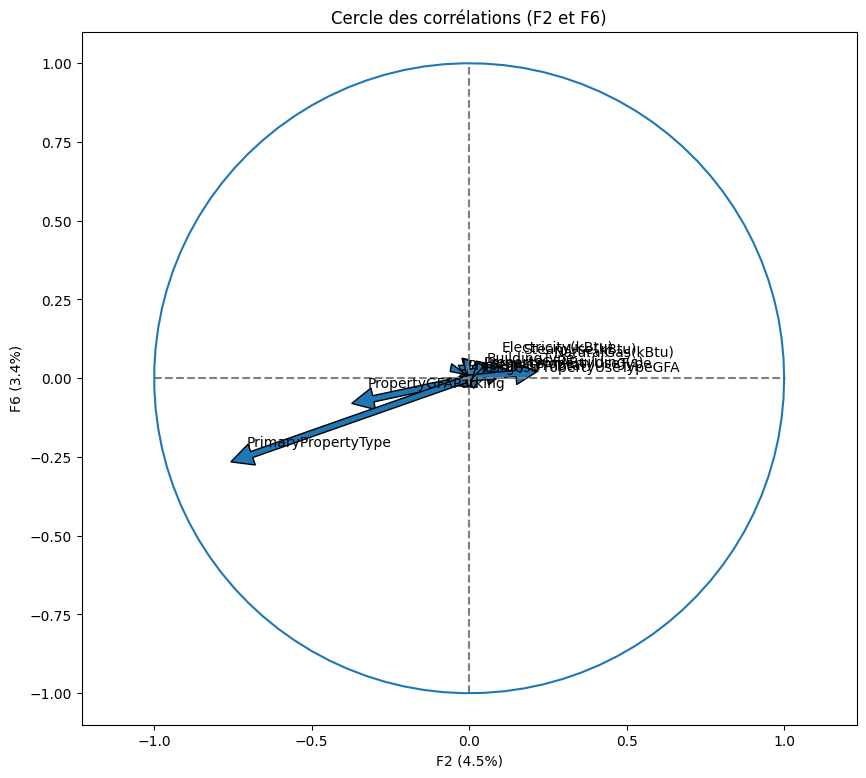

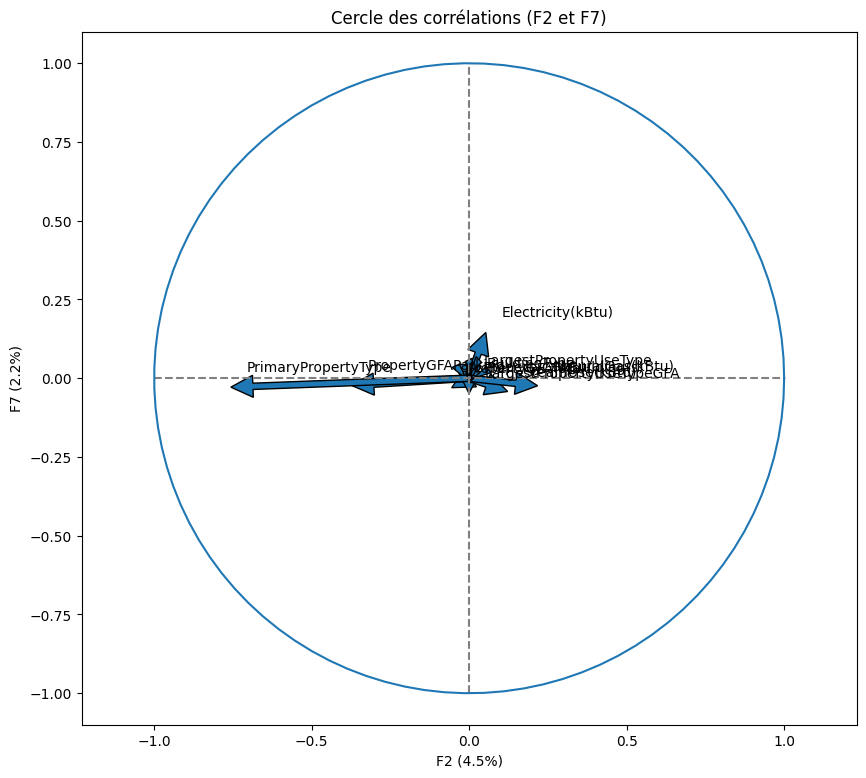

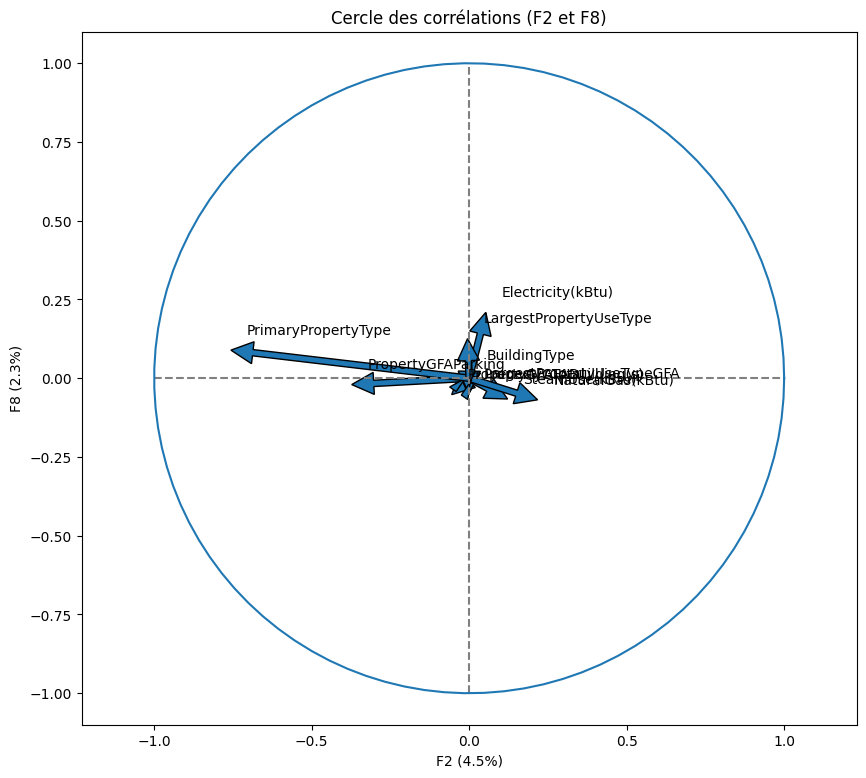

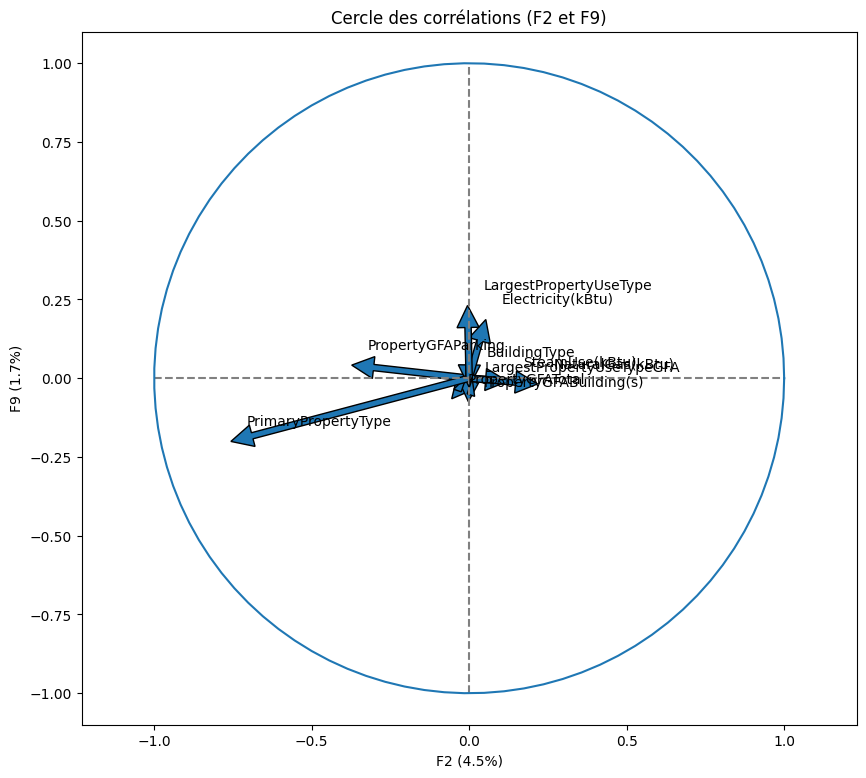

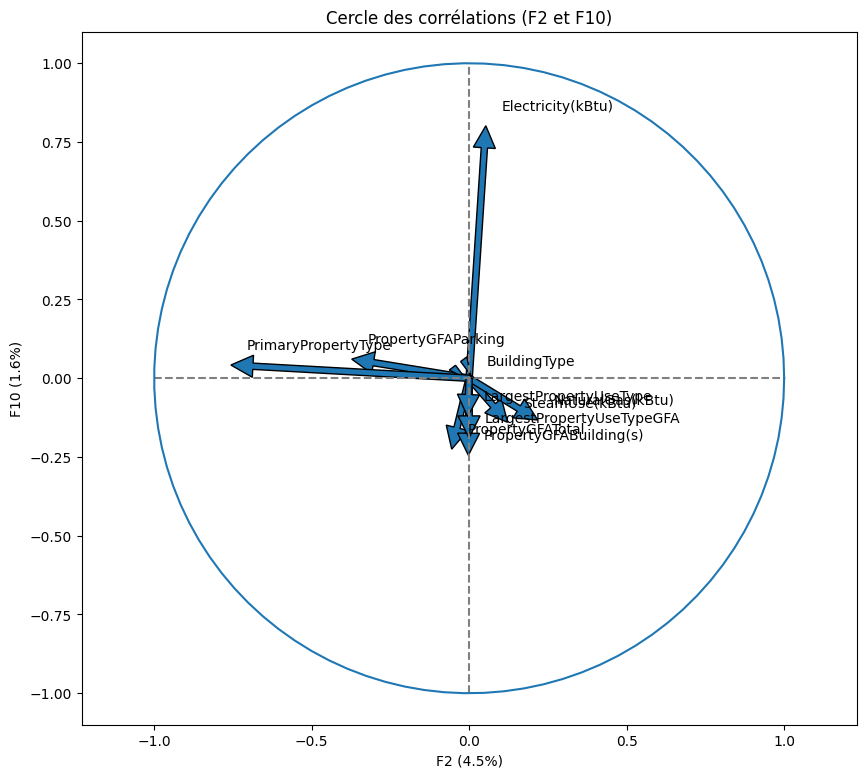

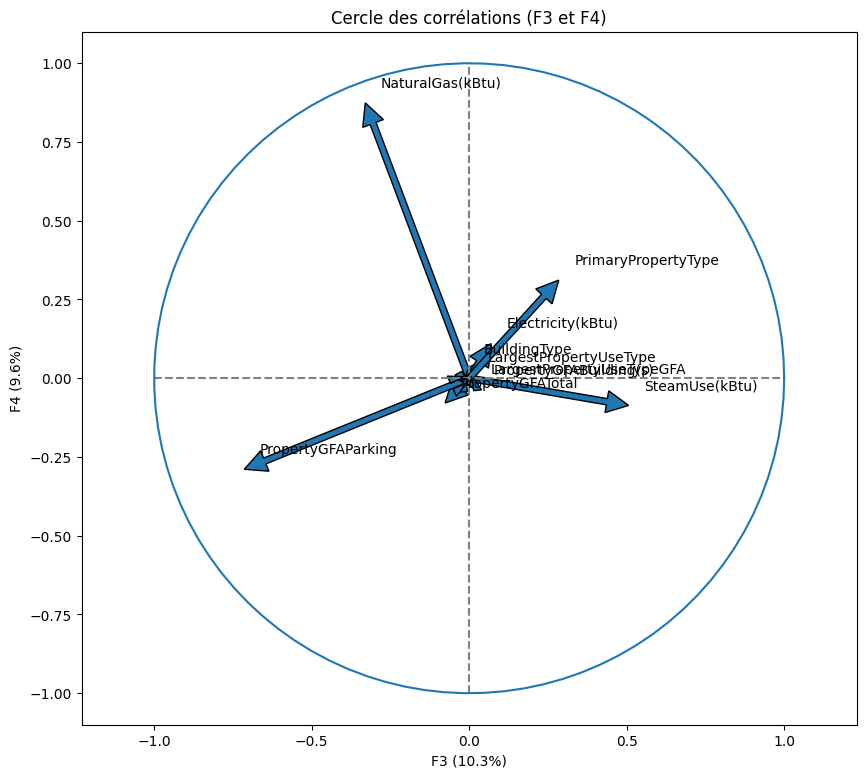

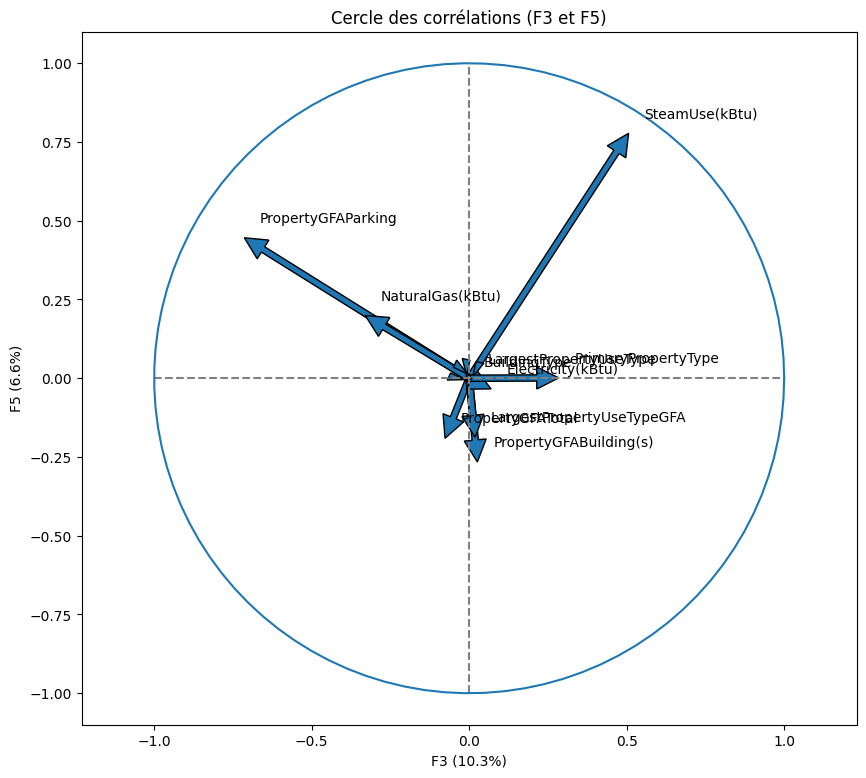

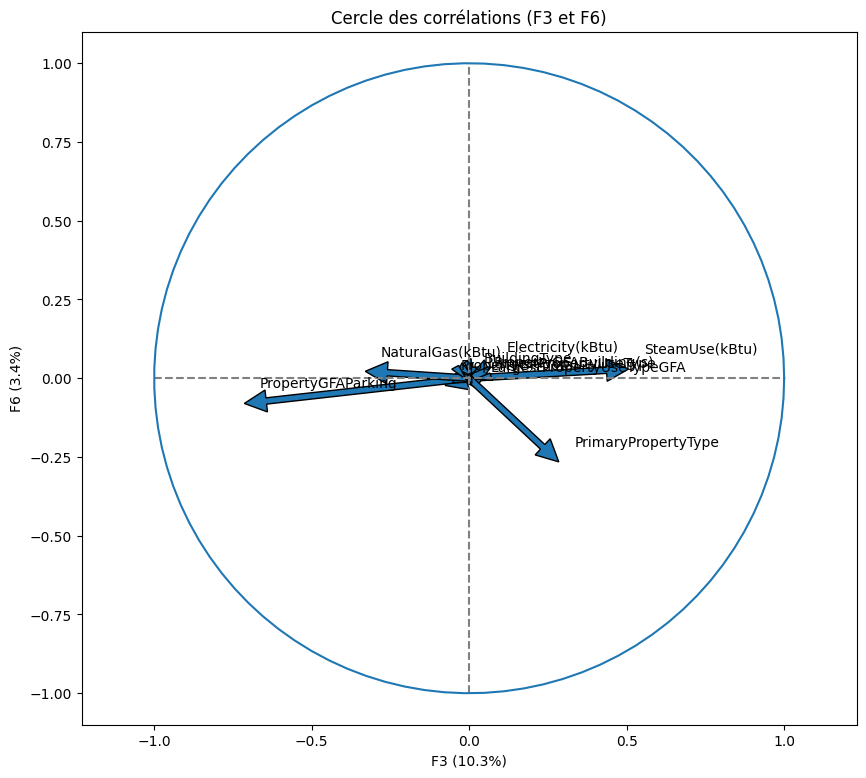

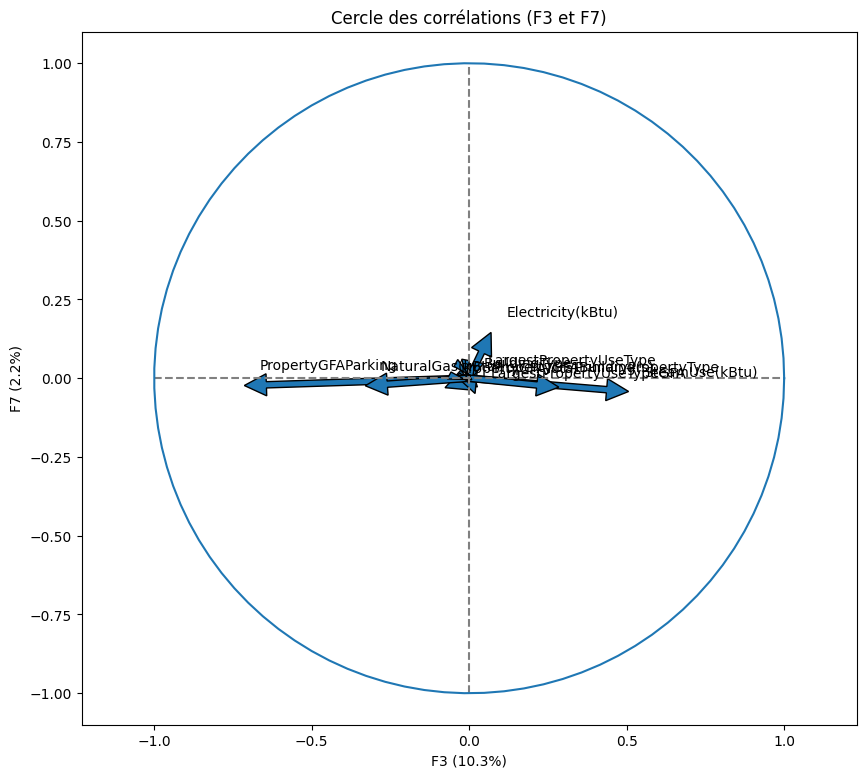

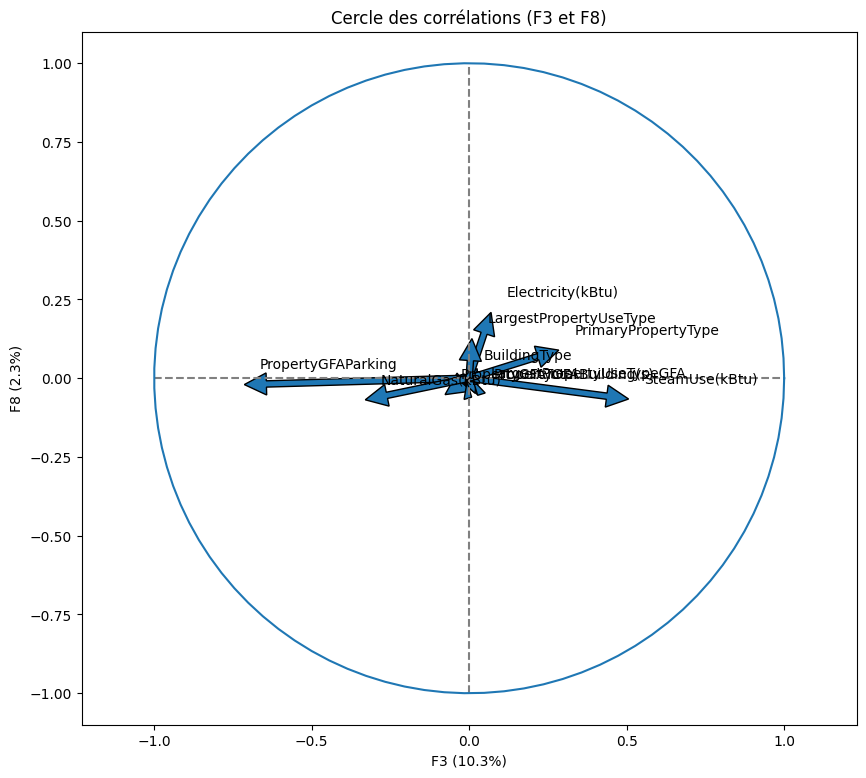

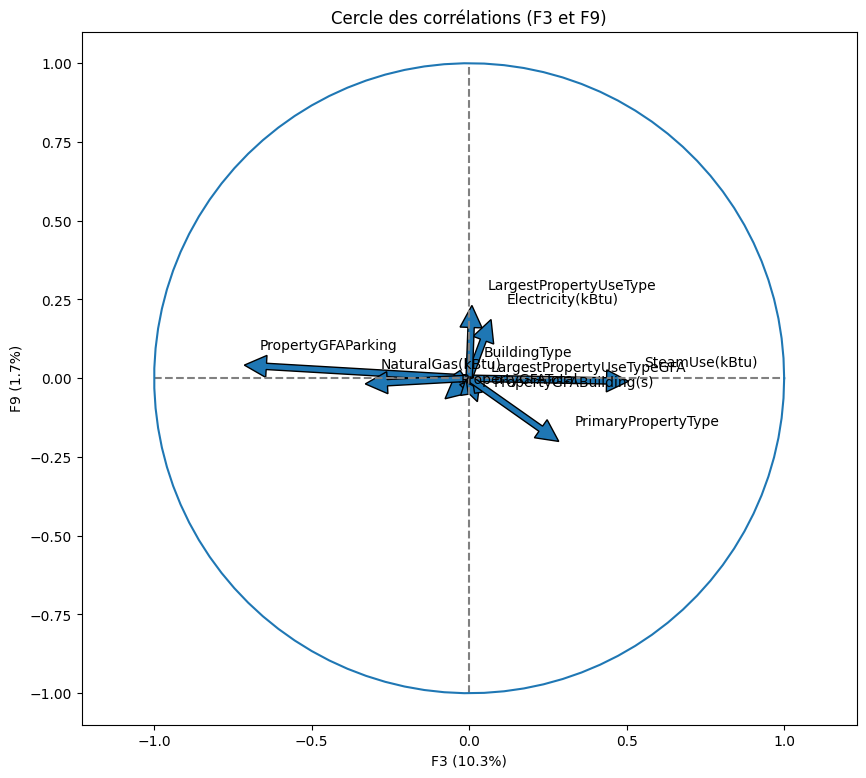

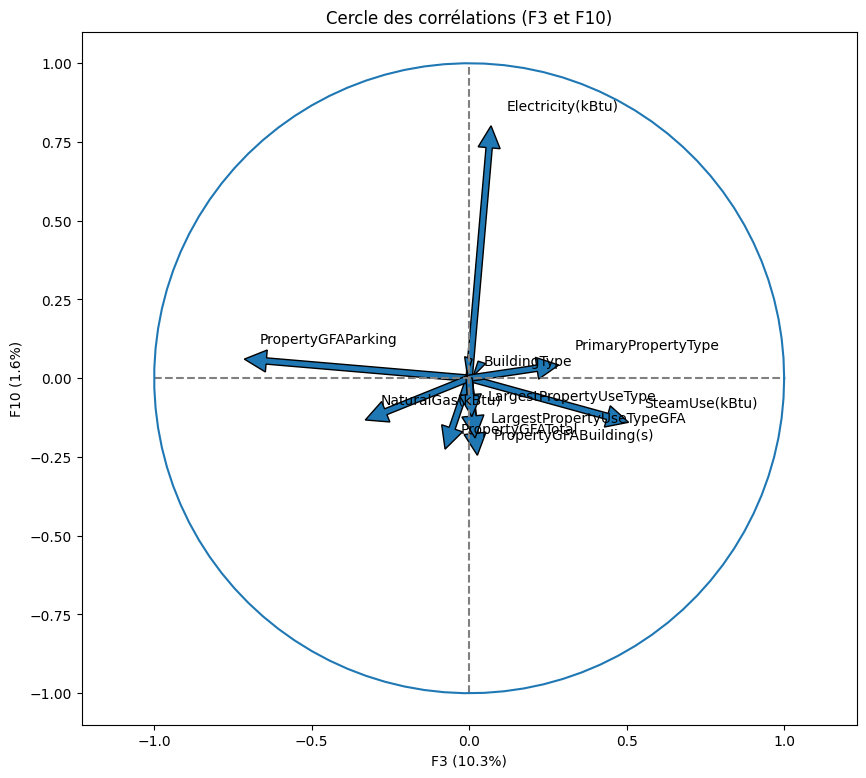

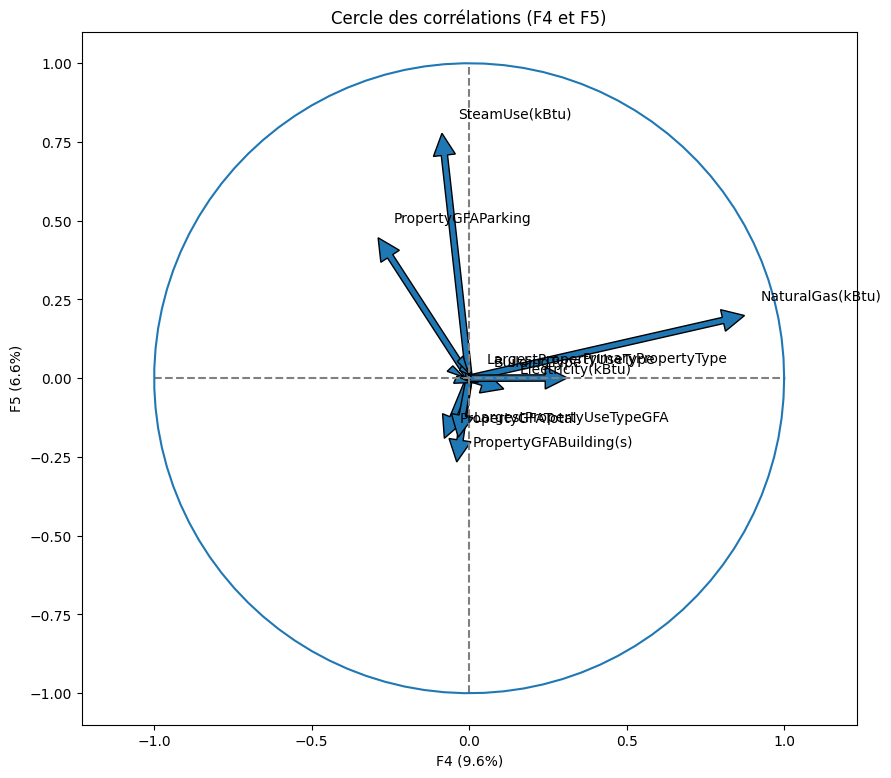

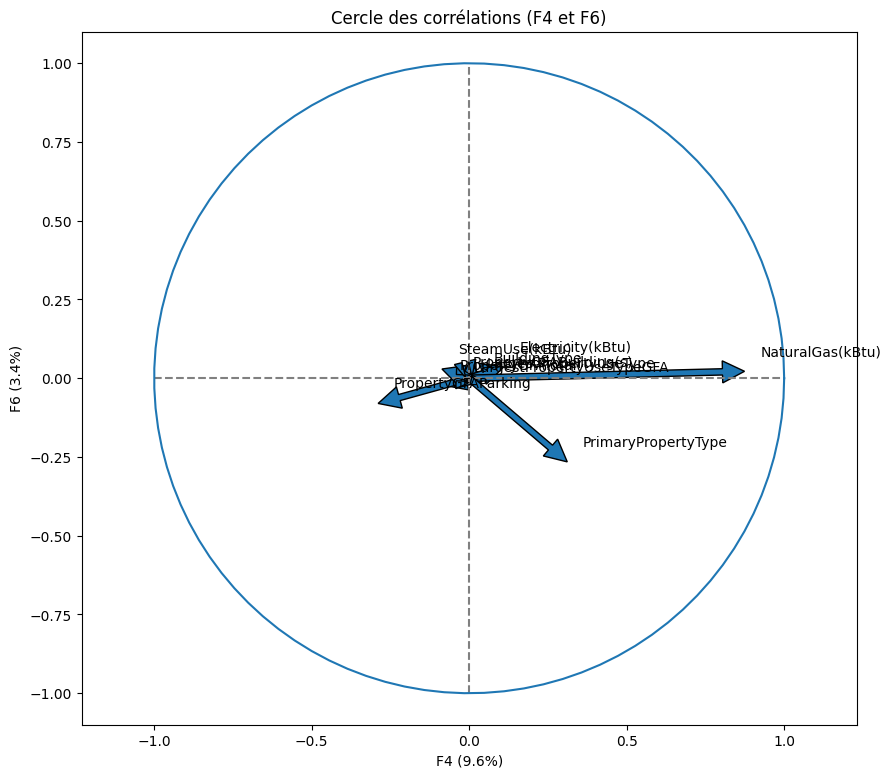

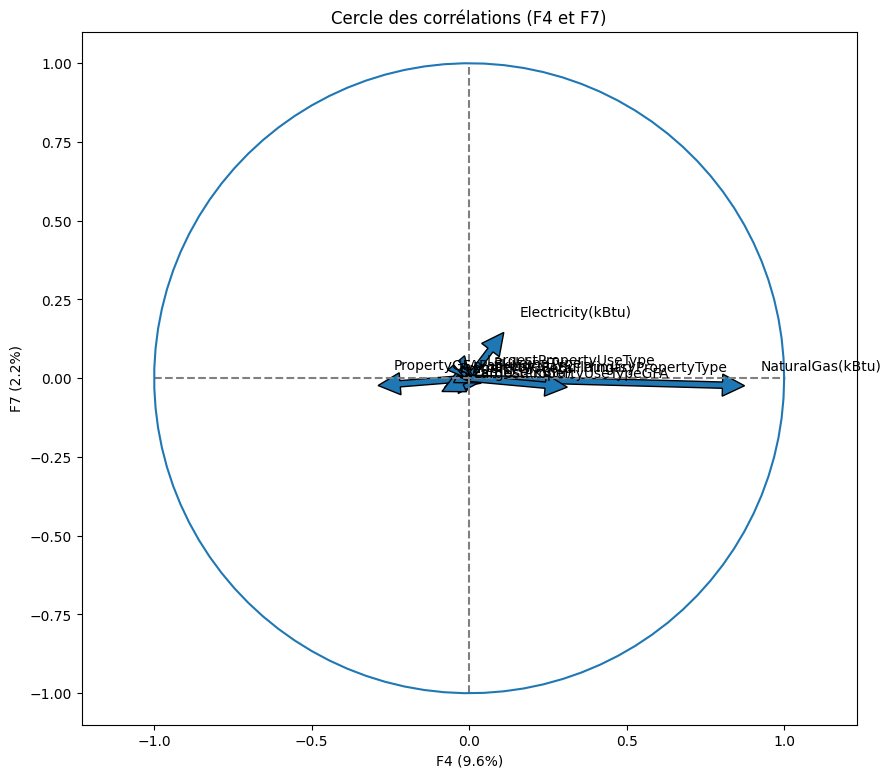

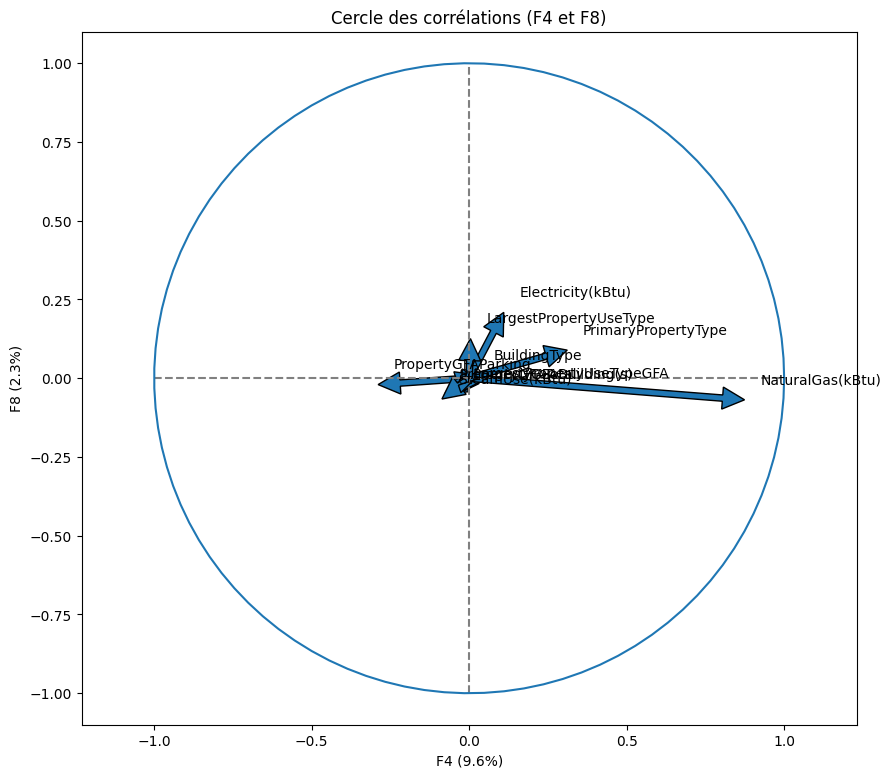

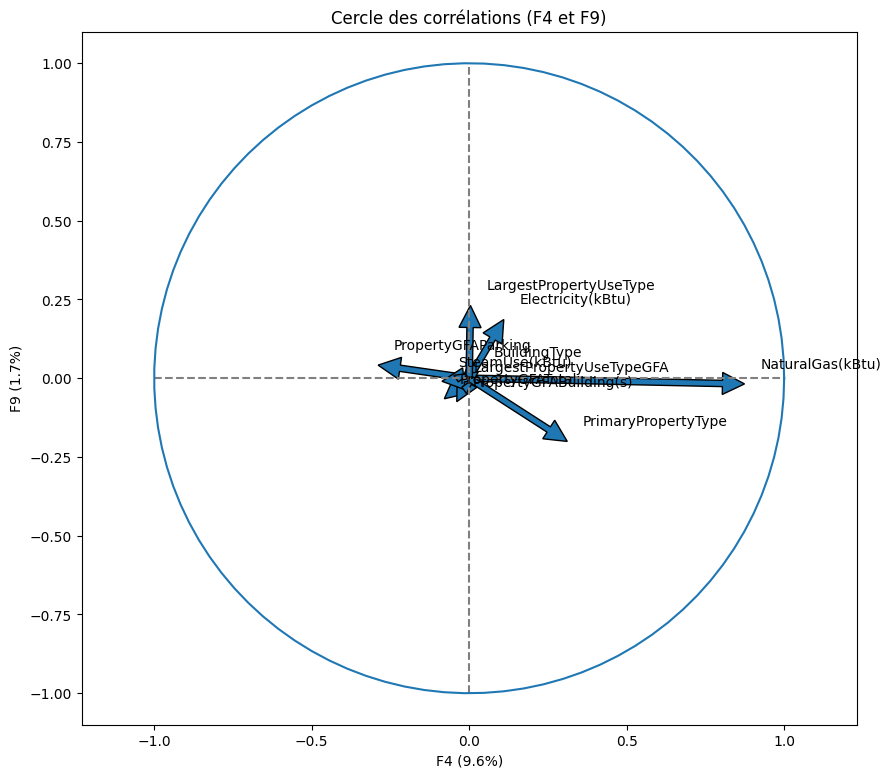

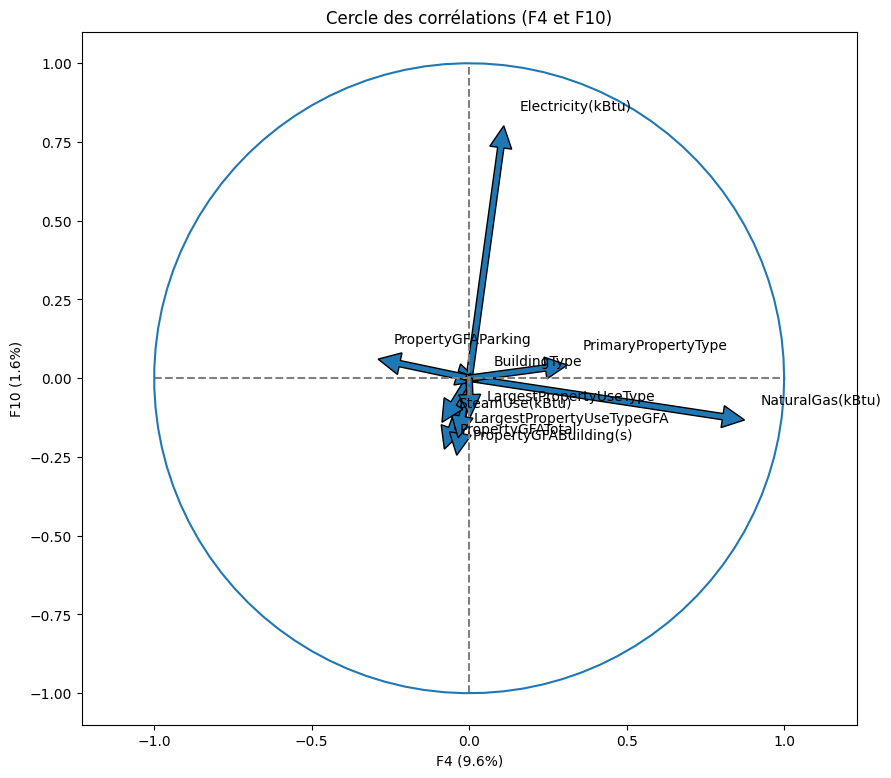

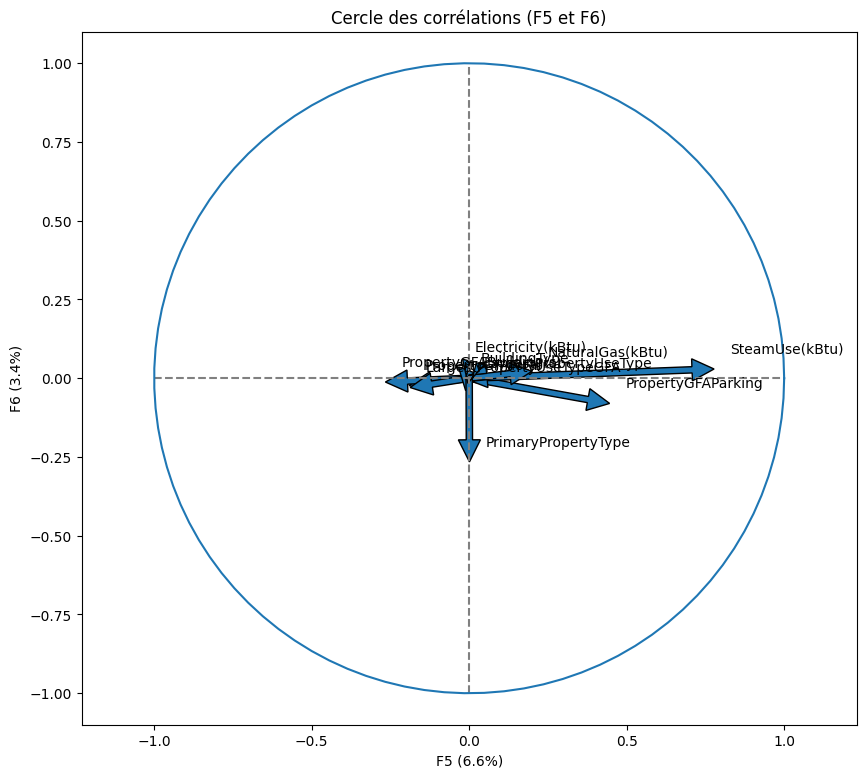

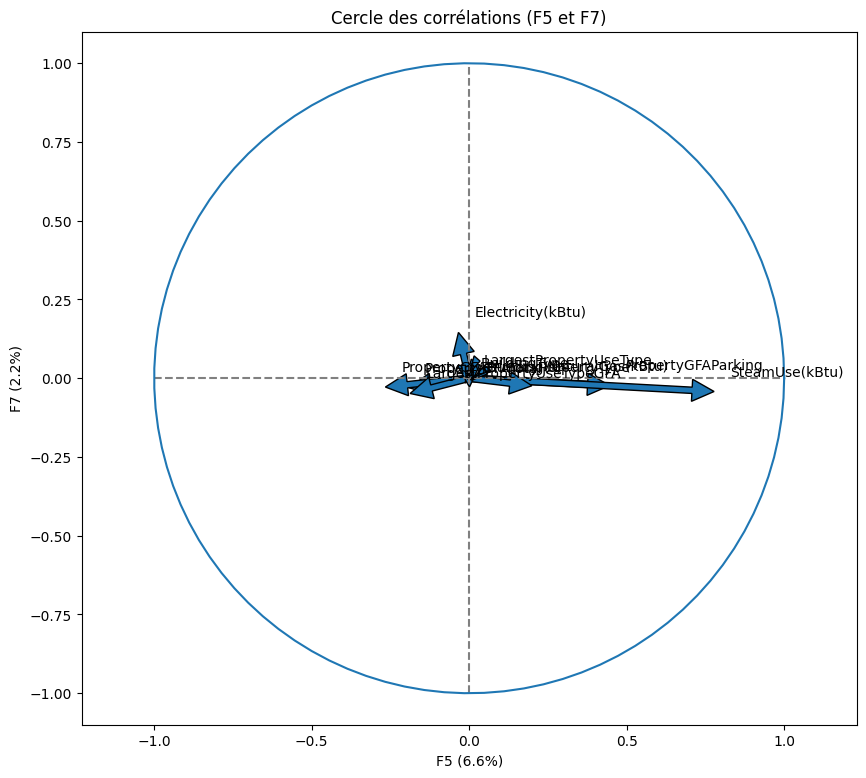

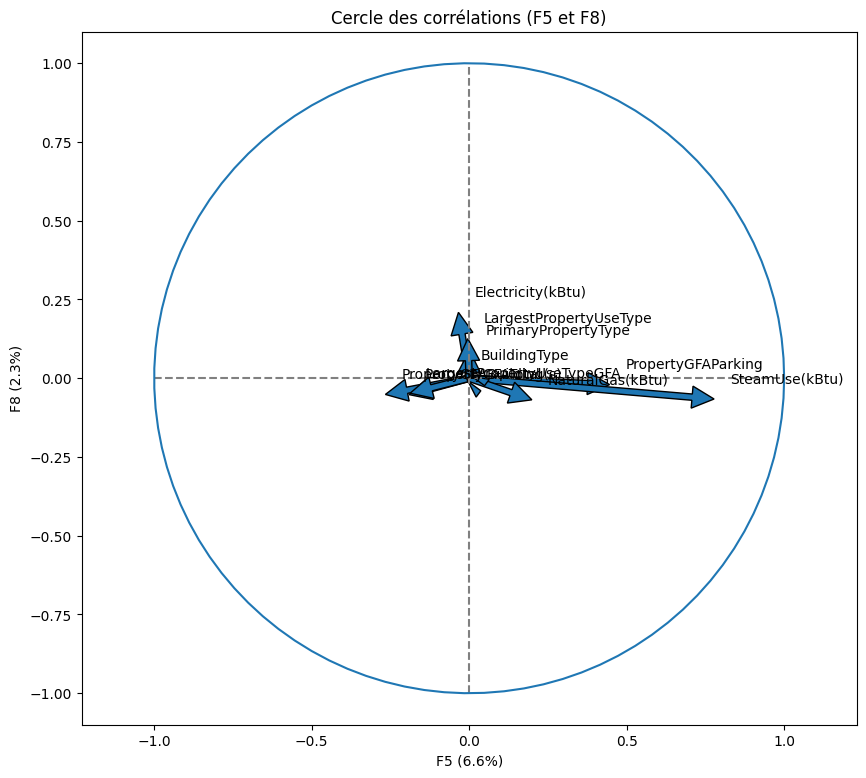

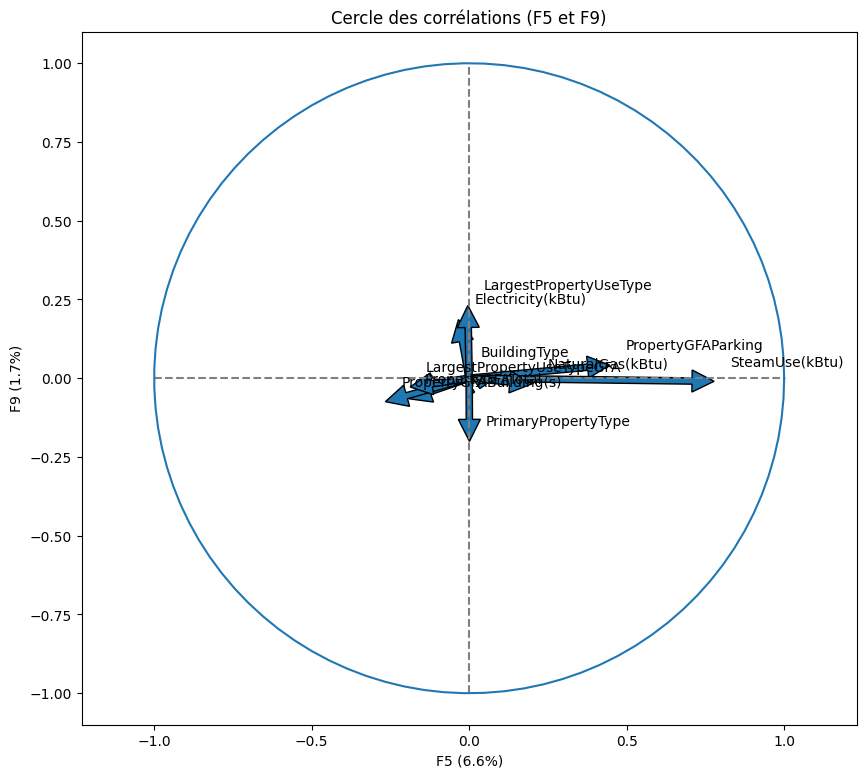

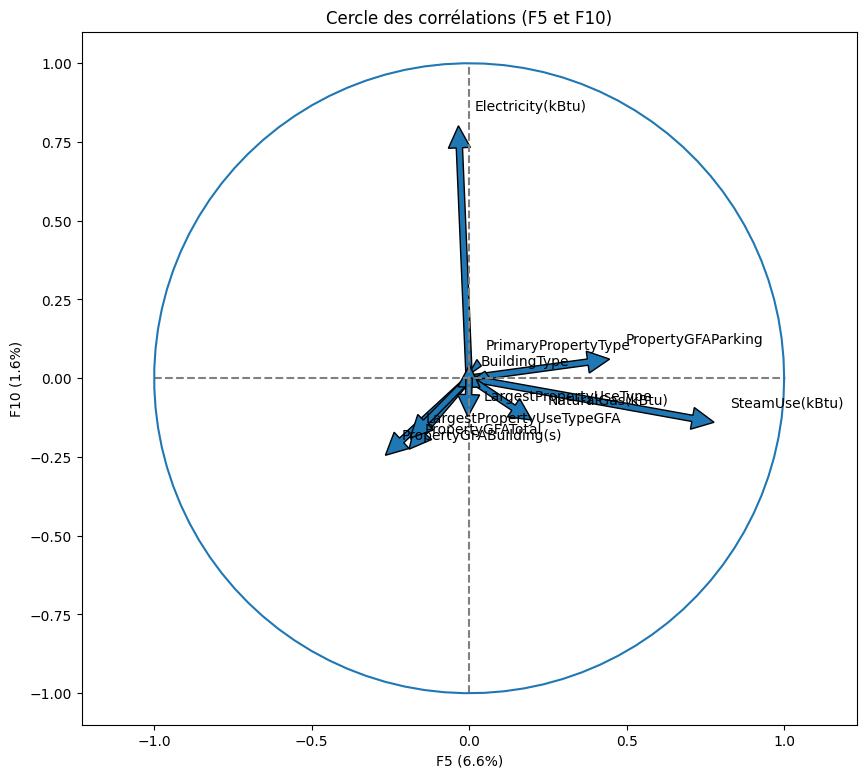

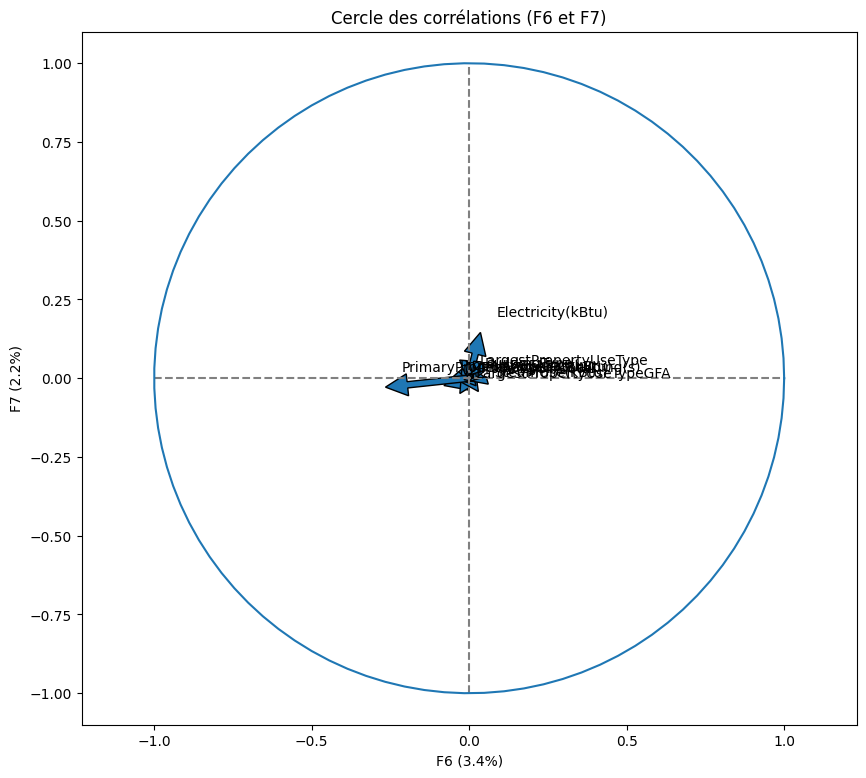

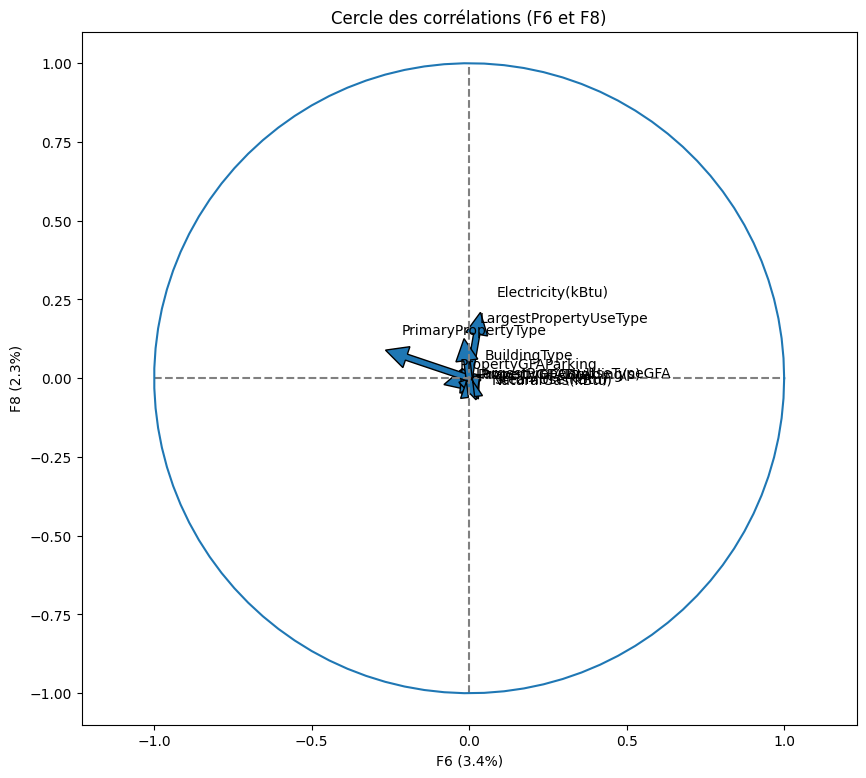

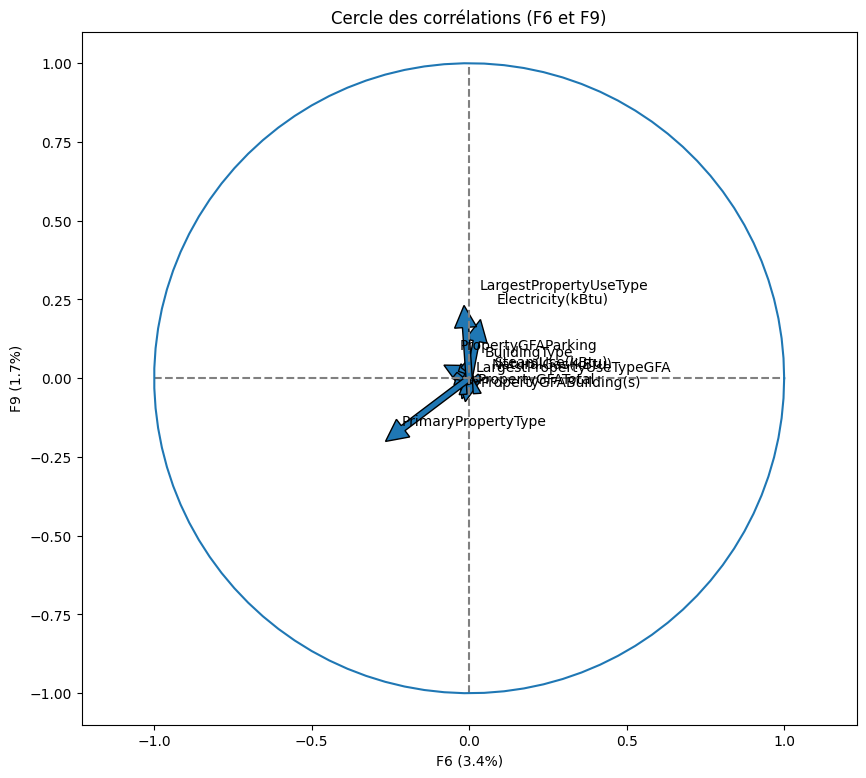

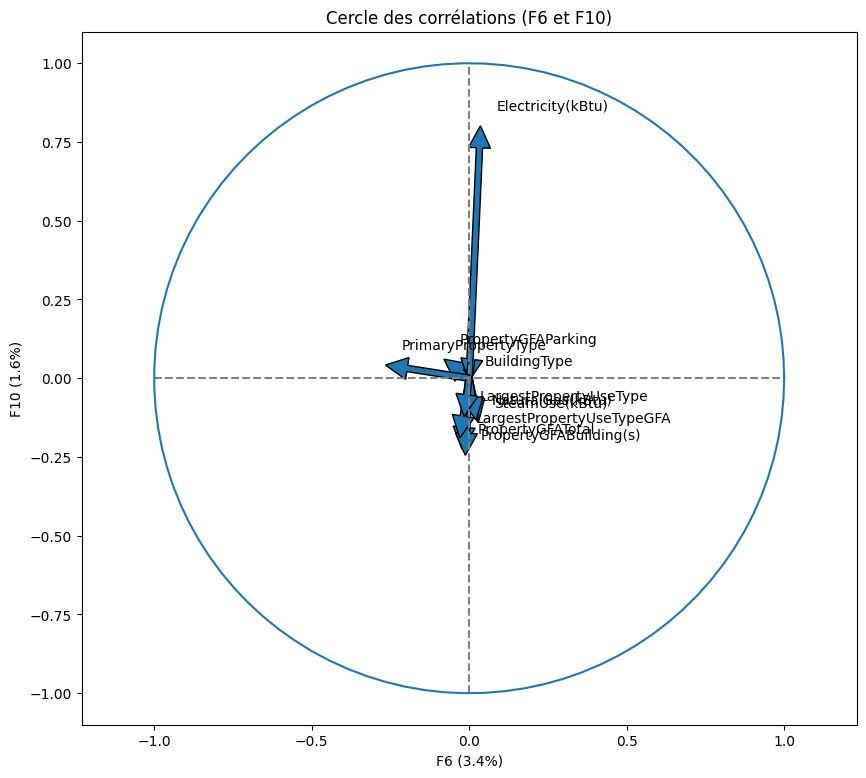

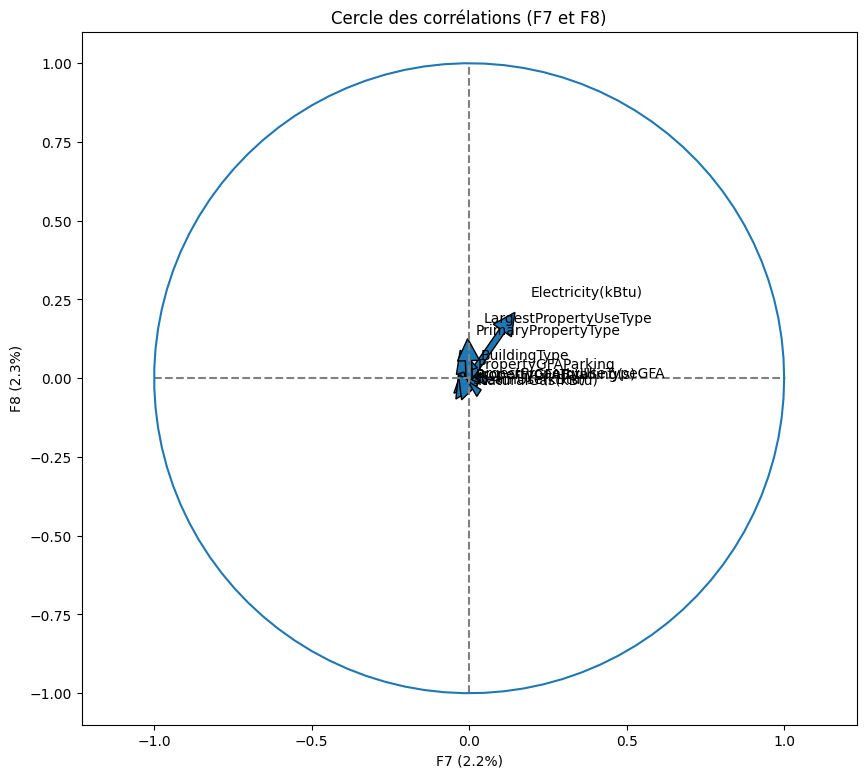

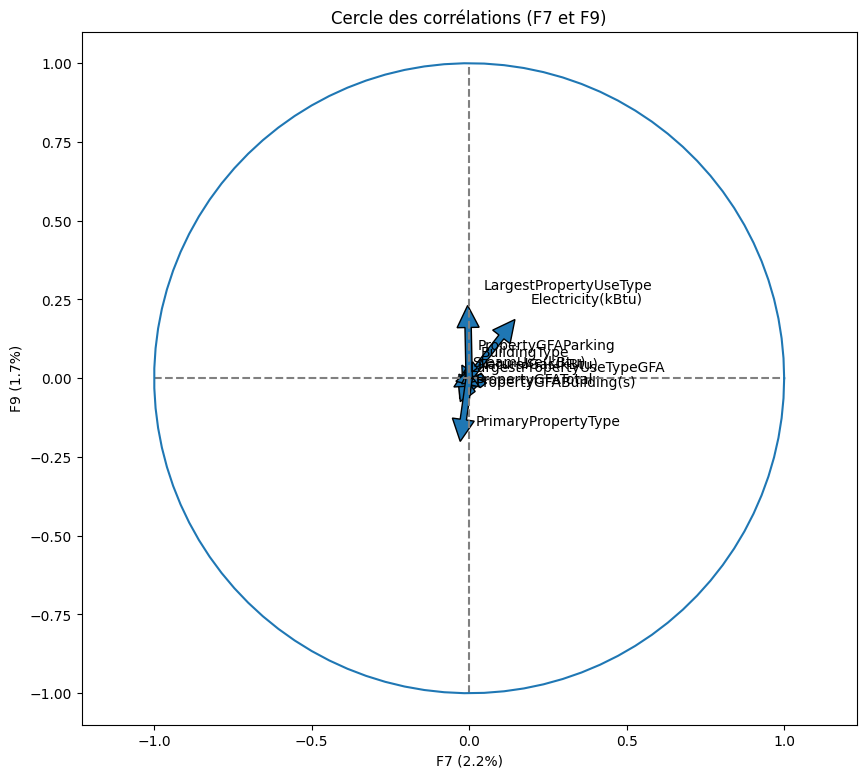

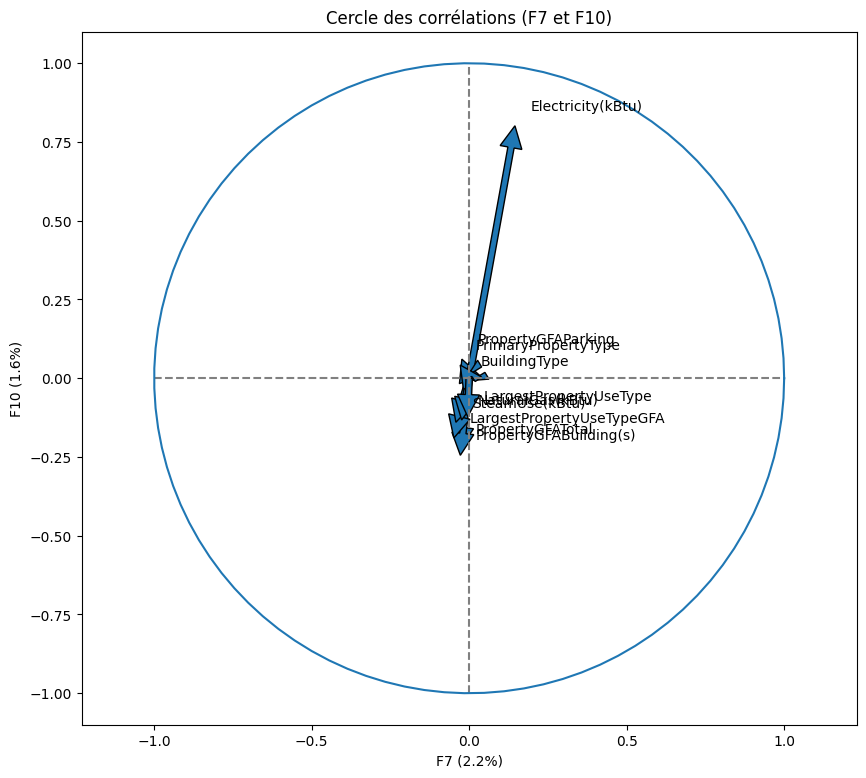

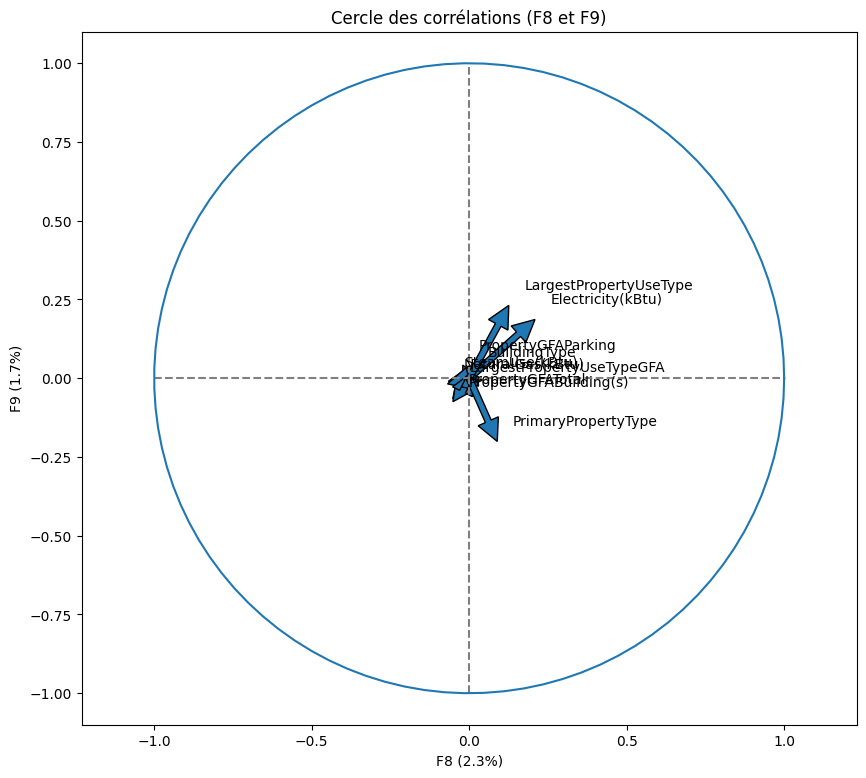

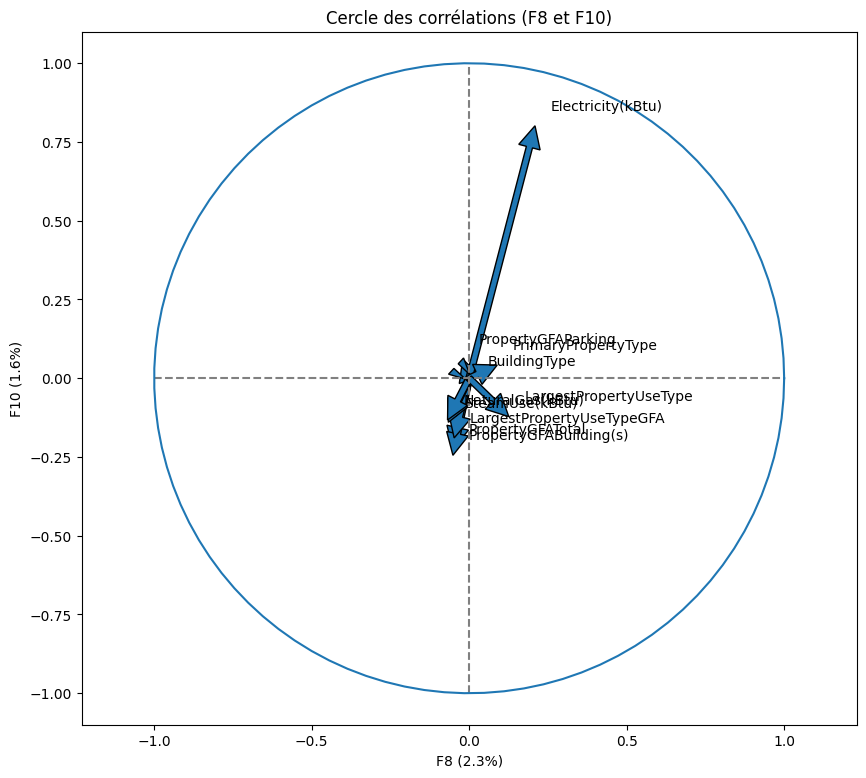

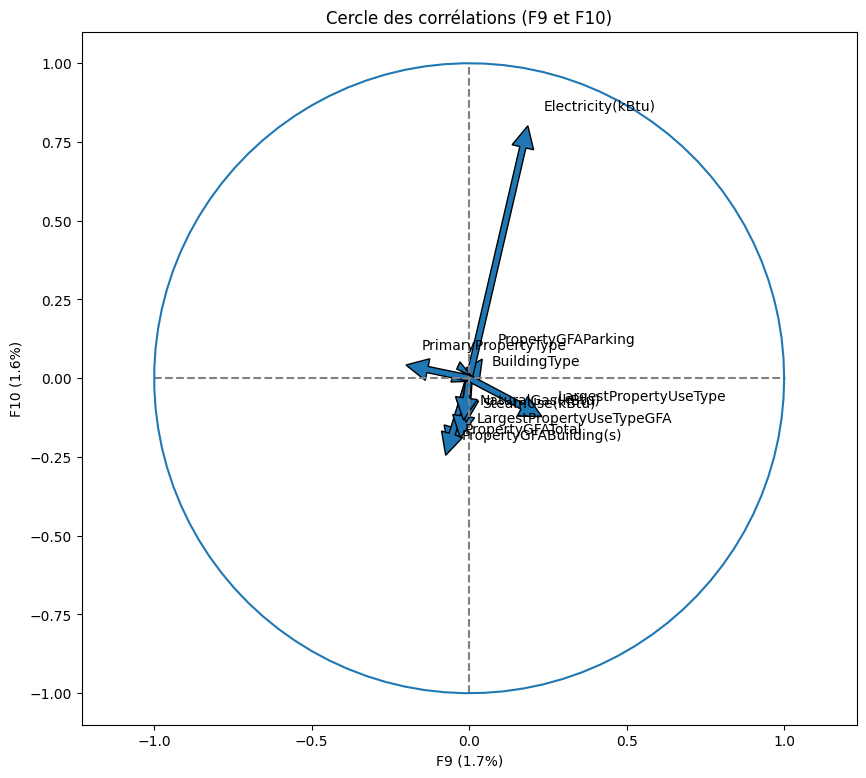

In [71]:
# Affichage des graphiques de corrélations des composantes
for x in range(0, n_components):
    for y in range(x + 1, n_components):
        x_y = (x, y)
        correlation_graph(truncatedsvd, x_y, columns_acp)

# Feature Engineering

In [72]:
transformed_data.head()

YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0       1927                1.0              12             88434   
1       1996                1.0              11            103566   
2       1969                1.0              41            956110   
3       1926                1.0              10             61320   
4       1980                1.0              18            175580   

   PropertyGFAParking  PropertyGFABuilding(s)    BuildingType  \
0                   0                   88434  NonResidential   
1               15064                   88502  NonResidential   
2              196718                  759392  NonResidential   
3                   0                   61320  NonResidential   
4               62000                  113580  NonResidential   

  PrimaryPropertyType      ListOfAllPropertyUseTypes LargestPropertyUseType  \
0               Hotel                          Hotel                  Hotel   
1               Hotel     Hotel, Parking, Restaurant                  Hotel   
2               Hotel                          Hotel                  Hotel   
3               Hotel                          Hotel                  Hotel   
4               Hotel  Hotel, Parking, Swimming Pool                  Hotel   

   ... LargestPropertyUseTypeGFA SecondLargestPropertyUseTypeGFA  \
0  ...                   88434.0                             0.0   
1  ...                   83880.0                         15064.0   
2  ...                  756493.0                             0.0   
3  ...                   61320.0                             0.0   
4  ...                  123445.0                         68009.0   

   ThirdLargestPropertyUseTypeGFA  SteamUse(kBtu)  Electricity(kBtu)  \
0                             0.0      2003882.00          3946027.0   
1                          4622.0            0.00          3242851.0   
2                             0.0     21566554.00         49526664.0   
3                             0.0      2214446.25          2768924.0   
4                             0.0            0.00          5368607.0   

   NaturalGas(kBtu)  SiteEnergyUse(kBtu)  SiteEUI(kBtu/sf)  ENERGYSTARScore  \
0         1276453.0            7226362.5         81.699997             60.0   
1         5145082.0            8387933.0         94.800003             61.0   
2         1493800.0           72587024.0         96.000000             43.0   
3         1811213.0            6794584.0        110.800003             56.0   
4         8803998.0           14172606.0        114.800003             75.0   

   TotalGHGEmissions  
0             249.98  
1             295.86  
2            2089.28  
3             286.43  
4             505.01  

[5 rows x 22 columns]

In [73]:
transformed_data["AgeBuilding"] = 2016 - transformed_data["YearBuilt"]

In [74]:
transformed_data["ProportionGFABuilding"] = transformed_data[
    "PropertyGFABuilding(s)"] / transformed_data["PropertyGFATotal"]

transformed_data["ProportionGFAParking"] = transformed_data[
    "PropertyGFAParking"] / transformed_data["PropertyGFATotal"]

In [75]:
transformed_data["ProportionElectricity"] = transformed_data[
    "Electricity(kBtu)"] / transformed_data["SiteEnergyUse(kBtu)"]

transformed_data["ProportionNaturalGas"] = transformed_data[
    "NaturalGas(kBtu)"] / transformed_data["SiteEnergyUse(kBtu)"]

transformed_data["ProportionSteamUse"] = transformed_data[
    "SteamUse(kBtu)"] / transformed_data["SiteEnergyUse(kBtu)"]

In [76]:
transformed_data["NumberofFloorsByBuildings"] = (
    transformed_data["NumberofFloors"] /
    transformed_data["NumberofBuildings"]).round()

In [77]:
transformed_data.describe()

C:\Users\Thomas\AppData\Local\pypoetry\Cache\virtualenvs\projet4-clnvXbUf-py3.11\Lib\site-packages\pandas\core\nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\Thomas\AppData\Local\pypoetry\Cache\virtualenvs\projet4-clnvXbUf-py3.11\Lib\site-packages\pandas\core\nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\Thomas\AppData\Local\pypoetry\Cache\virtualenvs\projet4-clnvXbUf-py3.11\Lib\site-packages\pandas\core\nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
count  1666.000000        1666.000000     1666.000000      1.666000e+03   
mean   1961.956783           1.168667        4.122449      1.189350e+05   
std      32.737659           2.931409        6.567141      2.975279e+05   
min    1900.000000           0.000000        0.000000      1.128500e+04   
25%    1930.000000           1.000000        1.000000      2.950050e+04   
50%    1965.000000           1.000000        2.000000      4.928950e+04   
75%    1989.000000           1.000000        4.000000      1.057750e+05   
max    2015.000000         111.000000       99.000000      9.320156e+06   

       PropertyGFAParking  PropertyGFABuilding(s)  LargestPropertyUseTypeGFA  \
count         1666.000000            1.666000e+03               1.666000e+03   
mean         12913.462785            1.060216e+05               9.865082e+04   
std          42297.528706            2.843726e+05               2.763892e+05   
min              0.000000            3.636000e+03               5.656000e+03   
25%              0.000000            2.849400e+04               2.554950e+04   
50%              0.000000            4.739150e+04               4.386650e+04   
75%              0.000000            9.485325e+04               9.186250e+04   
max         512608.000000            9.320156e+06               9.320156e+06   

       SecondLargestPropertyUseTypeGFA  ThirdLargestPropertyUseTypeGFA  \
count                      1666.000000                     1666.000000   
mean                      18934.106740                     3193.420505   
std                       53291.345015                    17983.399173   
min                           0.000000                        0.000000   
25%                           0.000000                        0.000000   
50%                           0.000000                        0.000000   
75%                       12712.000000                        0.000000   
max                      686750.000000                   459748.000000   

       SteamUse(kBtu)  ...  SiteEUI(kBtu/sf)  ENERGYSTARScore  \
count    1.666000e+03  ...       1665.000000      1094.000000   
mean     5.125726e+05  ...         72.158799        65.449726   
std      5.513944e+06  ...         74.048129        28.492928   
min      0.000000e+00  ...          0.000000         1.000000   
25%      0.000000e+00  ...         33.700001        48.000000   
50%      0.000000e+00  ...         51.900002        73.000000   
75%      0.000000e+00  ...         81.699997        89.000000   
max      1.349435e+08  ...        834.400024       100.000000   

       TotalGHGEmissions  AgeBuilding  ProportionGFABuilding  \
count        1666.000000  1666.000000            1666.000000   
mean          184.973301    54.043217               0.938813   
std           751.976001    32.737659               0.140143   
min            -0.800000     1.000000               0.104977   
25%            19.967500    27.000000               1.000000   
50%            49.580000    51.000000               1.000000   
75%           142.382500    86.000000               1.000000   
max         16870.980000   116.000000               1.000000   

       ProportionGFAParking  ProportionElectricity  ProportionNaturalGas  \
count           1666.000000            1657.000000           1654.000000   
mean               0.061187                    inf                   inf   
std                0.140143                    NaN                   NaN   
min                0.000000              -0.336762              0.000000   
25%                0.000000               0.486096              0.000000   
50%                0.000000               0.696785              0.245370   
75%                0.000000               0.999980              0.496308   
max                0.895023                    inf                   inf   

       ProportionSteamUse  NumberofFloorsByBuildings  
count         1650.000000                 

In [78]:
transformed_data.loc[transformed_data["ProportionElectricity"] == np.inf]=0
transformed_data.loc[transformed_data["ProportionNaturalGas"] == np.inf]=0
transformed_data.loc[transformed_data["NumberofFloorsByBuildings"] == np.inf]=0
transformed_data.describe()

YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
count  1666.000000        1666.000000     1666.000000      1.666000e+03   
mean   1888.901561           1.162065        3.989796      1.149870e+05   
std     372.868691           2.932908        6.565303      2.963126e+05   
min       0.000000           0.000000        0.000000      0.000000e+00   
25%    1928.000000           1.000000        1.000000      2.793425e+04   
50%    1964.000000           1.000000        2.000000      4.664500e+04   
75%    1988.000000           1.000000        4.000000      1.024475e+05   
max    2015.000000         111.000000       99.000000      9.320156e+06   

       PropertyGFAParking  PropertyGFABuilding(s)  LargestPropertyUseTypeGFA  \
count         1666.000000            1.666000e+03               1.666000e+03   
mean         12582.797119            1.024042e+05               9.544550e+04   
std          41973.272179            2.830504e+05               2.758616e+05   
min              0.000000            0.000000e+00               0.000000e+00   
25%              0.000000            2.699550e+04               2.401075e+04   
50%              0.000000            4.493000e+04               4.157050e+04   
75%              0.000000            9.154000e+04               8.783775e+04   
max         512608.000000            9.320156e+06               9.320156e+06   

       SecondLargestPropertyUseTypeGFA  ThirdLargestPropertyUseTypeGFA  \
count                      1666.000000                     1666.000000   
mean                      18386.881650                     2944.881489   
std                       52816.936005                    17041.378855   
min                           0.000000                        0.000000   
25%                           0.000000                        0.000000   
50%                           0.000000                        0.000000   
75%                       12000.000000                        0.000000   
max                      686750.000000                   459748.000000   

       SteamUse(kBtu)  ...  SiteEUI(kBtu/sf)  ENERGYSTARScore  \
count    1.666000e+03  ...       1665.000000      1133.000000   
mean     5.030202e+05  ...         69.152252        62.019417   
std      5.501574e+06  ...         72.531833        31.462996   
min      0.000000e+00  ...          0.000000         0.000000   
25%      0.000000e+00  ...         31.500000        40.000000   
50%      0.000000e+00  ...         50.299999        71.000000   
75%      0.000000e+00  ...         79.500000        89.000000   
max      1.349435e+08  ...        834.400024       100.000000   

       TotalGHGEmissions  AgeBuilding  ProportionGFABuilding  \
count        1666.000000  1666.000000            1666.000000   
mean          178.331020    52.073229               0.903214   
std           750.379704    33.761832               0.225057   
min            -0.800000     0.000000               0.000000   
25%            17.395000    24.000000               1.000000   
50%            46.670000    49.000000               1.000000   
75%           132.360000    85.000000               1.000000   
max         16870.980000   116.000000               1.000000   

       ProportionGFAParking  ProportionElectricity  ProportionNaturalGas  \
count           1666.000000            1661.000000           1661.000000   
mean               0.059571               0.669812              0.267946   
std                0.138693               0.291820              0.264976   
min                0.000000              -0.336762              0.000000   
25%                0.000000               0.459023              0.000000   
50%                0.000000               0.681914              0.220390   
75%                0.000000               0.996967              0.485086   
max                0.895023               1.000011              1.000000   

       ProportionSteamUse  NumberofFloorsByBuildings  
count         1661.000000                1

In [79]:
transformed_data = transformed_data[transformed_data["TotalGHGEmissions"]>0]

In [80]:
transformed_data = transformed_data.dropna(axis=0, subset="NumberofFloorsByBuildings")

In [81]:
transformed_data.isnull().mean()

YearBuilt                          0.000000
NumberofBuildings                  0.000000
NumberofFloors                     0.000000
PropertyGFATotal                   0.000000
PropertyGFAParking                 0.000000
PropertyGFABuilding(s)             0.000000
BuildingType                       0.000000
PrimaryPropertyType                0.000000
ListOfAllPropertyUseTypes          0.000000
LargestPropertyUseType             0.000000
SecondLargestPropertyUseType       0.000000
ThirdLargestPropertyUseType        0.000000
LargestPropertyUseTypeGFA          0.000000
SecondLargestPropertyUseTypeGFA    0.000000
ThirdLargestPropertyUseTypeGFA     0.000000
SteamUse(kBtu)                     0.000000
Electricity(kBtu)                  0.000000
NaturalGas(kBtu)                   0.000000
SiteEnergyUse(kBtu)                0.000000
SiteEUI(kBtu/sf)                   0.000000
ENERGYSTARScore                    0.331454
TotalGHGEmissions                  0.000000
AgeBuilding                     

In [82]:
transformed_data.to_csv("../Data/CleanData.csv")